In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy
import scipy.stats as spstat
from PIL import Image
import networkx as netx

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])])
    return lines

def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    init_fits = [[] for _ in range(nbr_gen)]
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
            init_fits[gen].append(init_fit)
            
        
    return best_fits, init_fits ,learn_delta, learn_prog    
    
    
def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def descOneId_to_descTwoIds(descriptors,pop_size):
    descriptors2 = []
    gen = 0
    ind = 0
    for desc in descriptors:
        if(desc[0] != 0 and desc[0]%pop_size == 0):
            gen+=1
            ind=0
        desc2 = [gen,ind] + desc[1:]
        ind+=1
        descriptors2.append(desc2)
    return descriptors2
        
def descriptors_to_nbr_of_types(descriptors):
    types_lines = []
    acc = 0
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    for desc in descriptors:
        if(mat[int(desc[5]*16)][int(desc[6]*16)][int(desc[7]*16)] == 0):
            mat[int(desc[5]*16)][int(desc[6]*16)][int(desc[7]*16)] = 1
            acc+=1
        if(desc[1] == 0):
            type_lines.append([desc[0],acc])
    return type_lines

def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        
        for o in range(len(tmp_desc)):
            spars = 0
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][1:])-np.array(tmp_desc[p][1:]))
                spars += dist
            sparsness.append([i,spars/pop_size])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()

def load_nbr_con_neu(filename):
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        nbr_con_neu = []
        for row in csv_data : 
            nbr_con_neu.append([int(row[0]),int(row[1]),int(row[2])])
    return nbr_con_neu

def load_lineage_gen(filename,ind_id,pop_size):
    parenting = dict()
    offsprings = dict() 
    id_to_gen_index = dict()
    i = 1
    index = 0
    generation = 0
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parenting[int(row[0])] = (int(row[1]),int(row[2]))
            id_to_gen_index[int(row[0])] = [generation,index]
            if(int(row[1]) in offsprings):
                offsprings[int(row[1])].append(int(row[0]))
            else:
                offsprings[int(row[1])] = [int(row[0])]
            if(int(row[2]) in offsprings):
                offsprings[int(row[2])].append(int(row[0]))
            else:
                offsprings[int(row[2])] = [int(row[0])]
            index+=1
            if(index >= pop_size):
                index = 0
                generation+=1
    return id_to_gen_index, offsprings, parenting


def build_lineage(parenting,ind_id):
    parent_id = parenting[ind_id]
    if(parent_id == -1):
        return []
    return [parent_id] + build_lineage(parenting,parent_id)

def load_lineage_monoparent_gen(filename,ind_id,pop_size):
    parenting = dict()
    offsprings = dict() 
    id_to_gen_index = dict()
    i = 1
    index = 0
    generation = 0
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parenting[int(row[0])] = int(row[i])
            id_to_gen_index[int(row[0])] = [generation,index]
            if(int(row[i]) in offsprings):
                offsprings[int(row[i])].append(int(row[0]))
            else:
                offsprings[int(row[i])] = [int(row[0])]
            if(i == 1):
                i = 2
            else:
                i = 1
            index+=1
            if(index >= pop_size):
                index = 0
                generation+=1
    return id_to_gen_index, offsprings ,[ind_id] + build_lineage(parenting,ind_id)

def compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,pop_size):
    sparsness = []
    for par,offs in offsprings.items():
        if(par < 0):
            continue
        spar = 0
        par_id = id_to_gen_index[par][0]*pop_size + id_to_gen_index[par][1]
        for o in offs:
            off_id = id_to_gen_index[o][0]*pop_size + id_to_gen_index[o][1]
            spar += np.linalg.norm(np.array(descriptors[par_id][1:]) - np.array(descriptors[off_id][1:]))
        sparsness.append([par,id_to_gen_index[par][0],spar,len(offs),spar/float(len(offs))])
    return sparsness

def draw_cppns(ids,folder):
    for id,i in zip(ids,range(len(ids))):
        plt.figure(figsize=(5,5))
        g = netx.nx_agraph.read_dot(folder + "/cppn_" + str(id) + ".dot")
        for k in g.nodes:
            g.nodes[k]['layer'] = int(g.nodes[k]['layer'])
        edge_labels = netx.get_edge_attributes(g,'label')
        edge_weights = []
        for (n1,n2,d), w in edge_labels.items():
            edge_weights.append((0,0,0,float(w)))
        print(edge_weights)
        node_labels = netx.get_node_attributes(g,'label')
        pos = netx.layout.multipartite_layout(g,subset_key='layer')
        pos2 = netx.layout.circular_layout(g.subgraph([str(i) for i in range(10,len(pos))]),scale=0.25)
        for k, p in pos.items():
            if(k in pos2):
                pos[k] = pos2[k]
        options = {
            "node_size": 1000,
            "edge_color": edge_weights,
            "edge_cmap": plt.cm.Blues
        }
        netx.draw(g,pos=pos,**options)
        netx.draw_networkx_labels(g,pos,node_labels)
    return edge_labels, node_labels

In [32]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_allp01/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

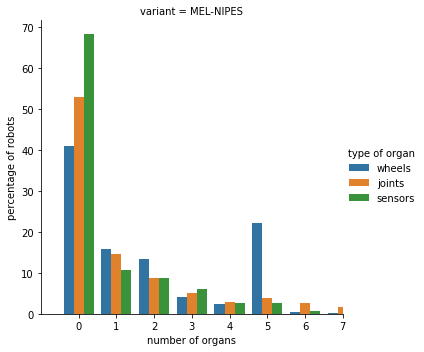

In [25]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [4]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_24_8_14-25-1-1049-51983


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), <a list of 6 Text yticklabel objects>)

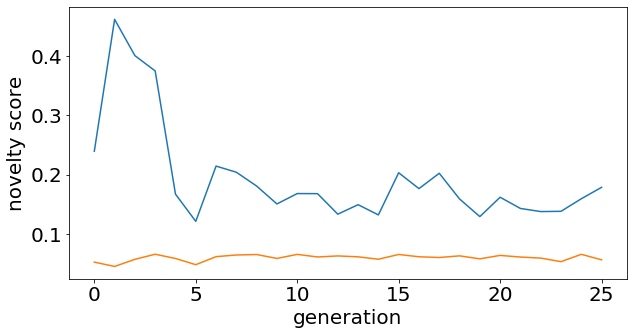

In [5]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [27]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_24_8_14-25-1-1049-51983


(array([15., 16., 17., 18., 19., 20., 21.]),
 <a list of 7 Text yticklabel objects>)

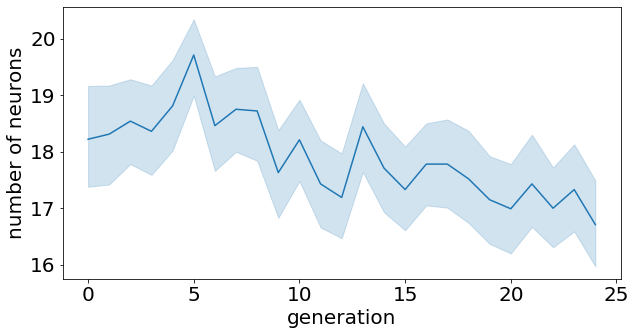

In [28]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([100., 200., 300., 400., 500., 600., 700.]),
 <a list of 7 Text yticklabel objects>)

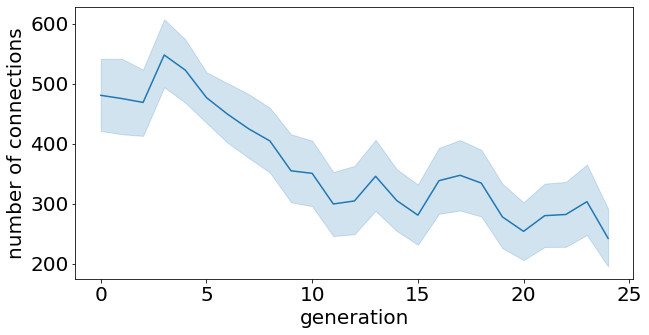

In [29]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ]),
 <a list of 9 Text yticklabel objects>)

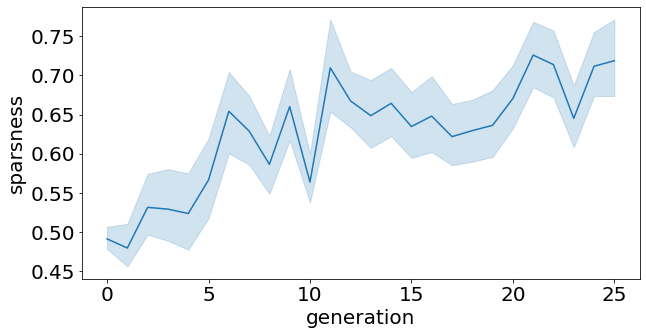

In [34]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_24_8_14-25-1-1049-51983/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
big_data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=big_data,x="generation",y="sparsness")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_24_8_14-25-1-1049-51983/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.histplot(data=data,x="sparsness",bins=100)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.histplot(data=data,x="number of offsprings",bins=100)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

[4994, 556, 176, 69]
[[25, 59], [3, 46], [1, 58], [0, 69]]
[[22, 583], [22, 584], [22, 584], [22, 584]]


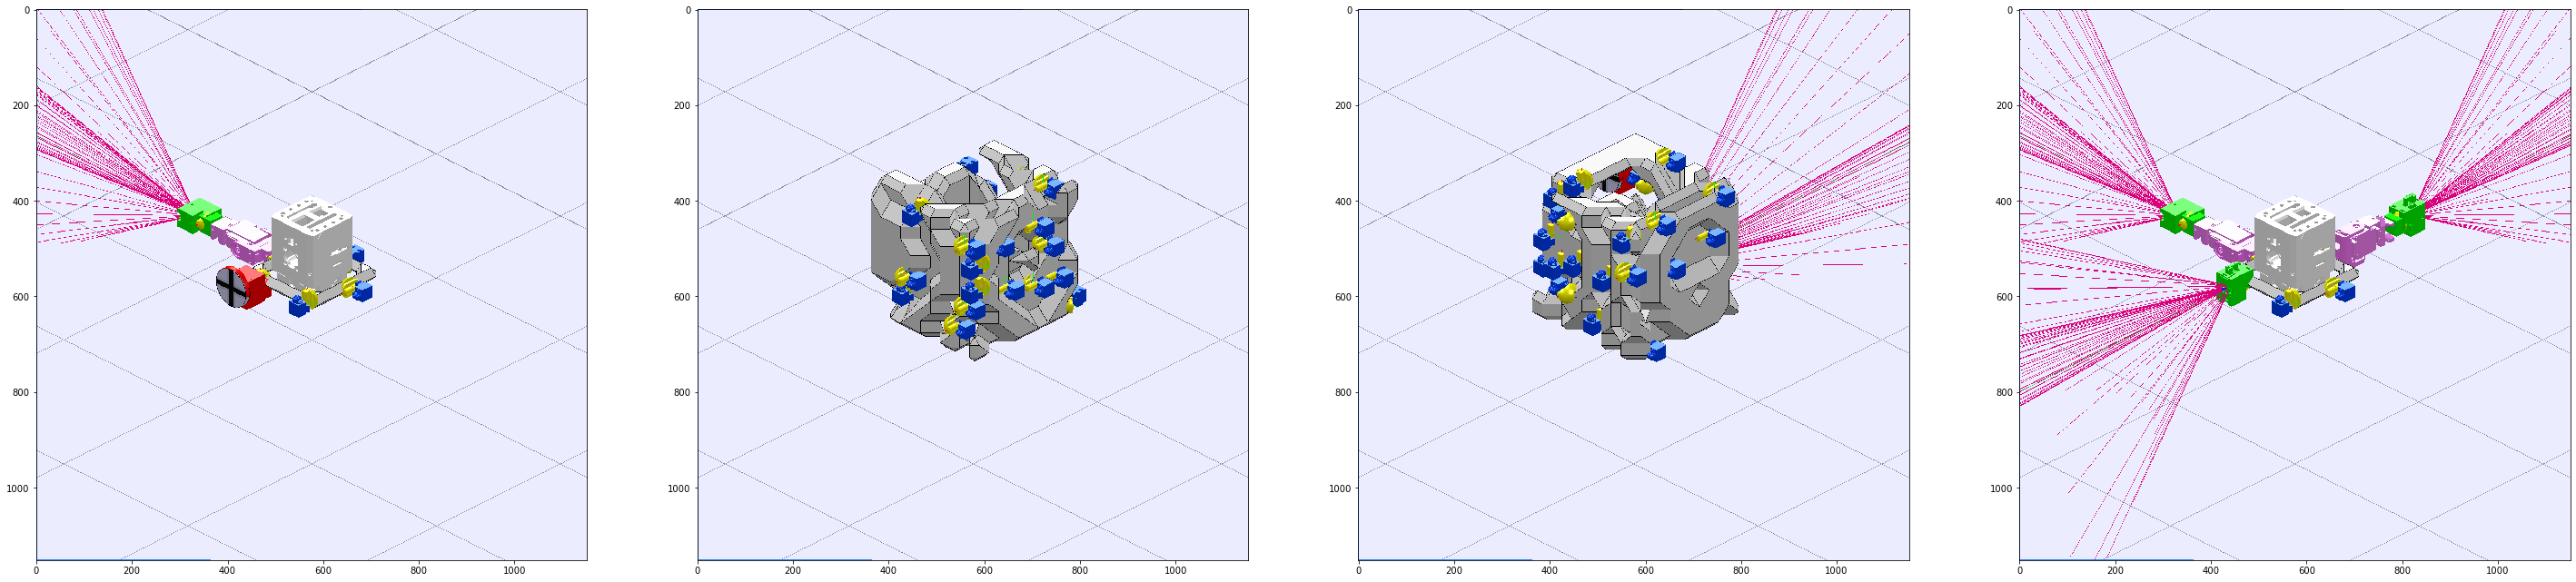

In [31]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/parenting.csv",4994,100)

nb_con_neu = load_nbr_con_neu(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/nbr_conn_neu.csv")
nbr_conn_neur = dict()
for ncn in nb_con_neu:
    nbr_conn_neur[ncn[0]] = ncn[1:]
print(lineage)
print([id_to_gen_index[l] for l in lineage])
print([nbr_conn_neur[l] for l in lineage])

images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

{'0': Text(-0.1983471074380165, 0.2727272727272727, 'i_0'),
 '1': Text(-0.1983471074380165, 0.09090909090909091, 'i_1'),
 '2': Text(-0.1983471074380165, -0.09090909090909091, 'i_2'),
 '3': Text(-0.1983471074380165, -0.2727272727272727, 'i_3'),
 '4': Text(0.1652892561983471, 0.4545454545454546, 'o_4'),
 '5': Text(0.1652892561983471, 0.2727272727272727, 'o_5'),
 '6': Text(0.1652892561983471, 0.09090909090909091, 'o_6'),
 '7': Text(0.1652892561983471, -0.09090909090909091, 'o_7'),
 '8': Text(0.1652892561983471, -0.2727272727272727, 'o_8'),
 '9': Text(0.1652892561983471, -0.4545454545454546, 'o_9'),
 '10': Text(-0.0983471074380165, 1.0, 'sin_0.115298_0.61238'),
 '11': Text(-0.0883471074380165, 0.8181818181818182, 'sigm_0.257653_0.940198'),
 '12': Text(-0.07834710743801651, 0.6363636363636364, 'lin_0.850076_0.772907'),
 '13': Text(-0.0683471074380165, 0.4545454545454546, 'gaus_0.233718_0.776456'),
 '14': Text(-0.05834710743801649, 0.2727272727272727, 'sigm_0.313229_0.866863'),
 '15': Text(-

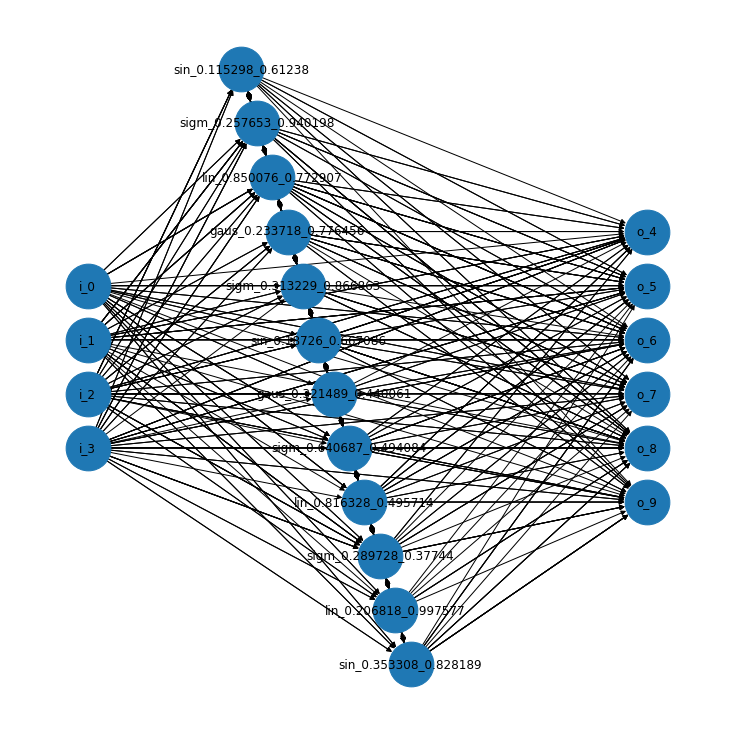

In [296]:
g = netx.nx_agraph.read_dot(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/morph_genome_69.dot")
for k in g.nodes:
    g.nodes[k]['layer'] = int(g.nodes[k]['layer'])
edge_labels = netx.get_edge_attributes(g,'label')
node_labels = netx.get_node_attributes(g,'label')
pos = netx.layout.multipartite_layout(g,subset_key='layer')
for k, p in pos.items():
    if(int(k) > 9):
        p[0,] = pos['0'][0,] + int(k)/100.
plt.figure(figsize=(10,10))
netx.draw(g,pos=pos,node_size=2000)
netx.draw_networkx_labels(g,pos,node_labels)

{'0': Text(-0.1983471074380165, 0.2727272727272727, 'i_0'),
 '1': Text(-0.1983471074380165, 0.09090909090909091, 'i_1'),
 '2': Text(-0.1983471074380165, -0.09090909090909091, 'i_2'),
 '3': Text(-0.1983471074380165, -0.2727272727272727, 'i_3'),
 '4': Text(0.1652892561983471, 0.4545454545454546, 'o_4'),
 '5': Text(0.1652892561983471, 0.2727272727272727, 'o_5'),
 '6': Text(0.1652892561983471, 0.09090909090909091, 'o_6'),
 '7': Text(0.1652892561983471, -0.09090909090909091, 'o_7'),
 '8': Text(0.1652892561983471, -0.2727272727272727, 'o_8'),
 '9': Text(0.1652892561983471, -0.4545454545454546, 'o_9'),
 '10': Text(-0.0983471074380165, 1.0, 'sin_0.115298_0.61238'),
 '11': Text(-0.0883471074380165, 0.8181818181818182, 'sigm_0.257653_1.12474'),
 '12': Text(-0.07834710743801651, 0.6363636363636364, 'lin_0.850076_0.743515'),
 '13': Text(-0.0683471074380165, 0.4545454545454546, 'gaus_0.233718_0.776456'),
 '14': Text(-0.05834710743801649, 0.2727272727272727, 'sigm_0.49976_0.866863'),
 '15': Text(-0.

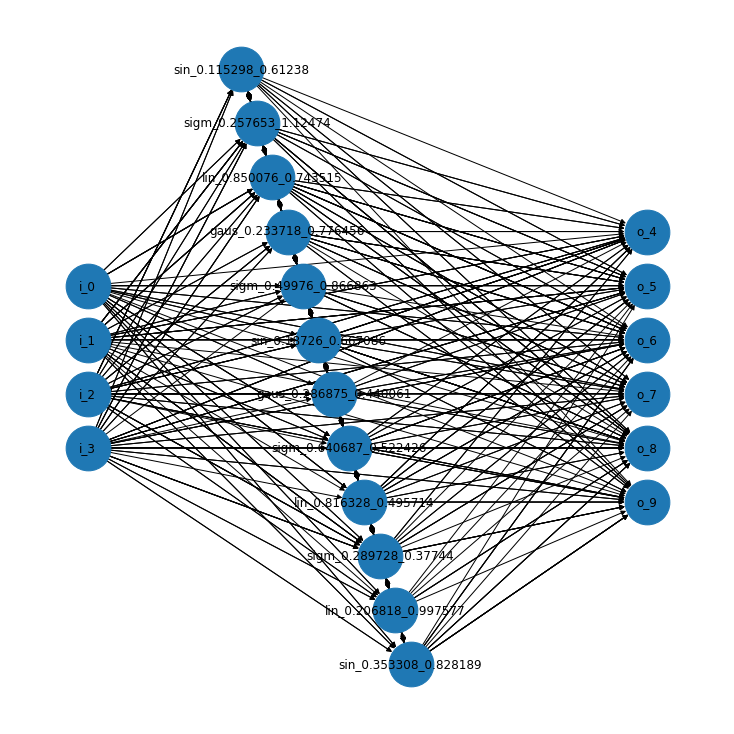

In [297]:
g = netx.nx_agraph.read_dot(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/morph_genome_176.dot")
for k in g.nodes:
    g.nodes[k]['layer'] = int(g.nodes[k]['layer'])
edge_labels = netx.get_edge_attributes(g,'label')
node_labels = netx.get_node_attributes(g,'label')
pos = netx.layout.multipartite_layout(g,subset_key='layer')
for k, p in pos.items():
    if(int(k) > 9):
        p[0,] = pos['0'][0,] + int(k)/100.
plt.figure(figsize=(10,10))
netx.draw(g,pos=pos,node_size=2000)
netx.draw_networkx_labels(g,pos,node_labels)

[176, 349, 355, 317, 566, 733, 944, 999, 933, 962, 1130, 1137, 1133, 1509, 1521, 1753, 1911, 1943, 2532, 2753, 3133, 3366, 3367, 3599, 3705, 4186, 4352, 4363, 4793, 4949]
[[1, 58], [2, 6], [2, 7], [2, 14], [3, 84], [4, 29], [5, 22], [5, 71], [5, 78], [5, 81], [6, 4], [6, 5], [6, 30], [8, 2], [8, 85], [9, 79], [10, 61], [10, 67], [13, 40], [14, 78], [16, 54], [17, 45], [17, 58], [18, 35], [19, 4], [21, 65], [22, 45], [22, 54], [24, 76], [25, 65]]
[[22, 584], [22, 584], [23, 585], [22, 532], [22, 584], [22, 584], [22, 584], [23, 584], [21, 507], [22, 584], [22, 584], [21, 525], [22, 584], [22, 584], [22, 584], [23, 585], [22, 584], [23, 585], [22, 584], [22, 583], [22, 584], [22, 584], [22, 584], [22, 583], [22, 584], [22, 584], [22, 584], [21, 512], [22, 582], [22, 582]]
[0, 22.309127814403656, 30, 0.7436375938134552]


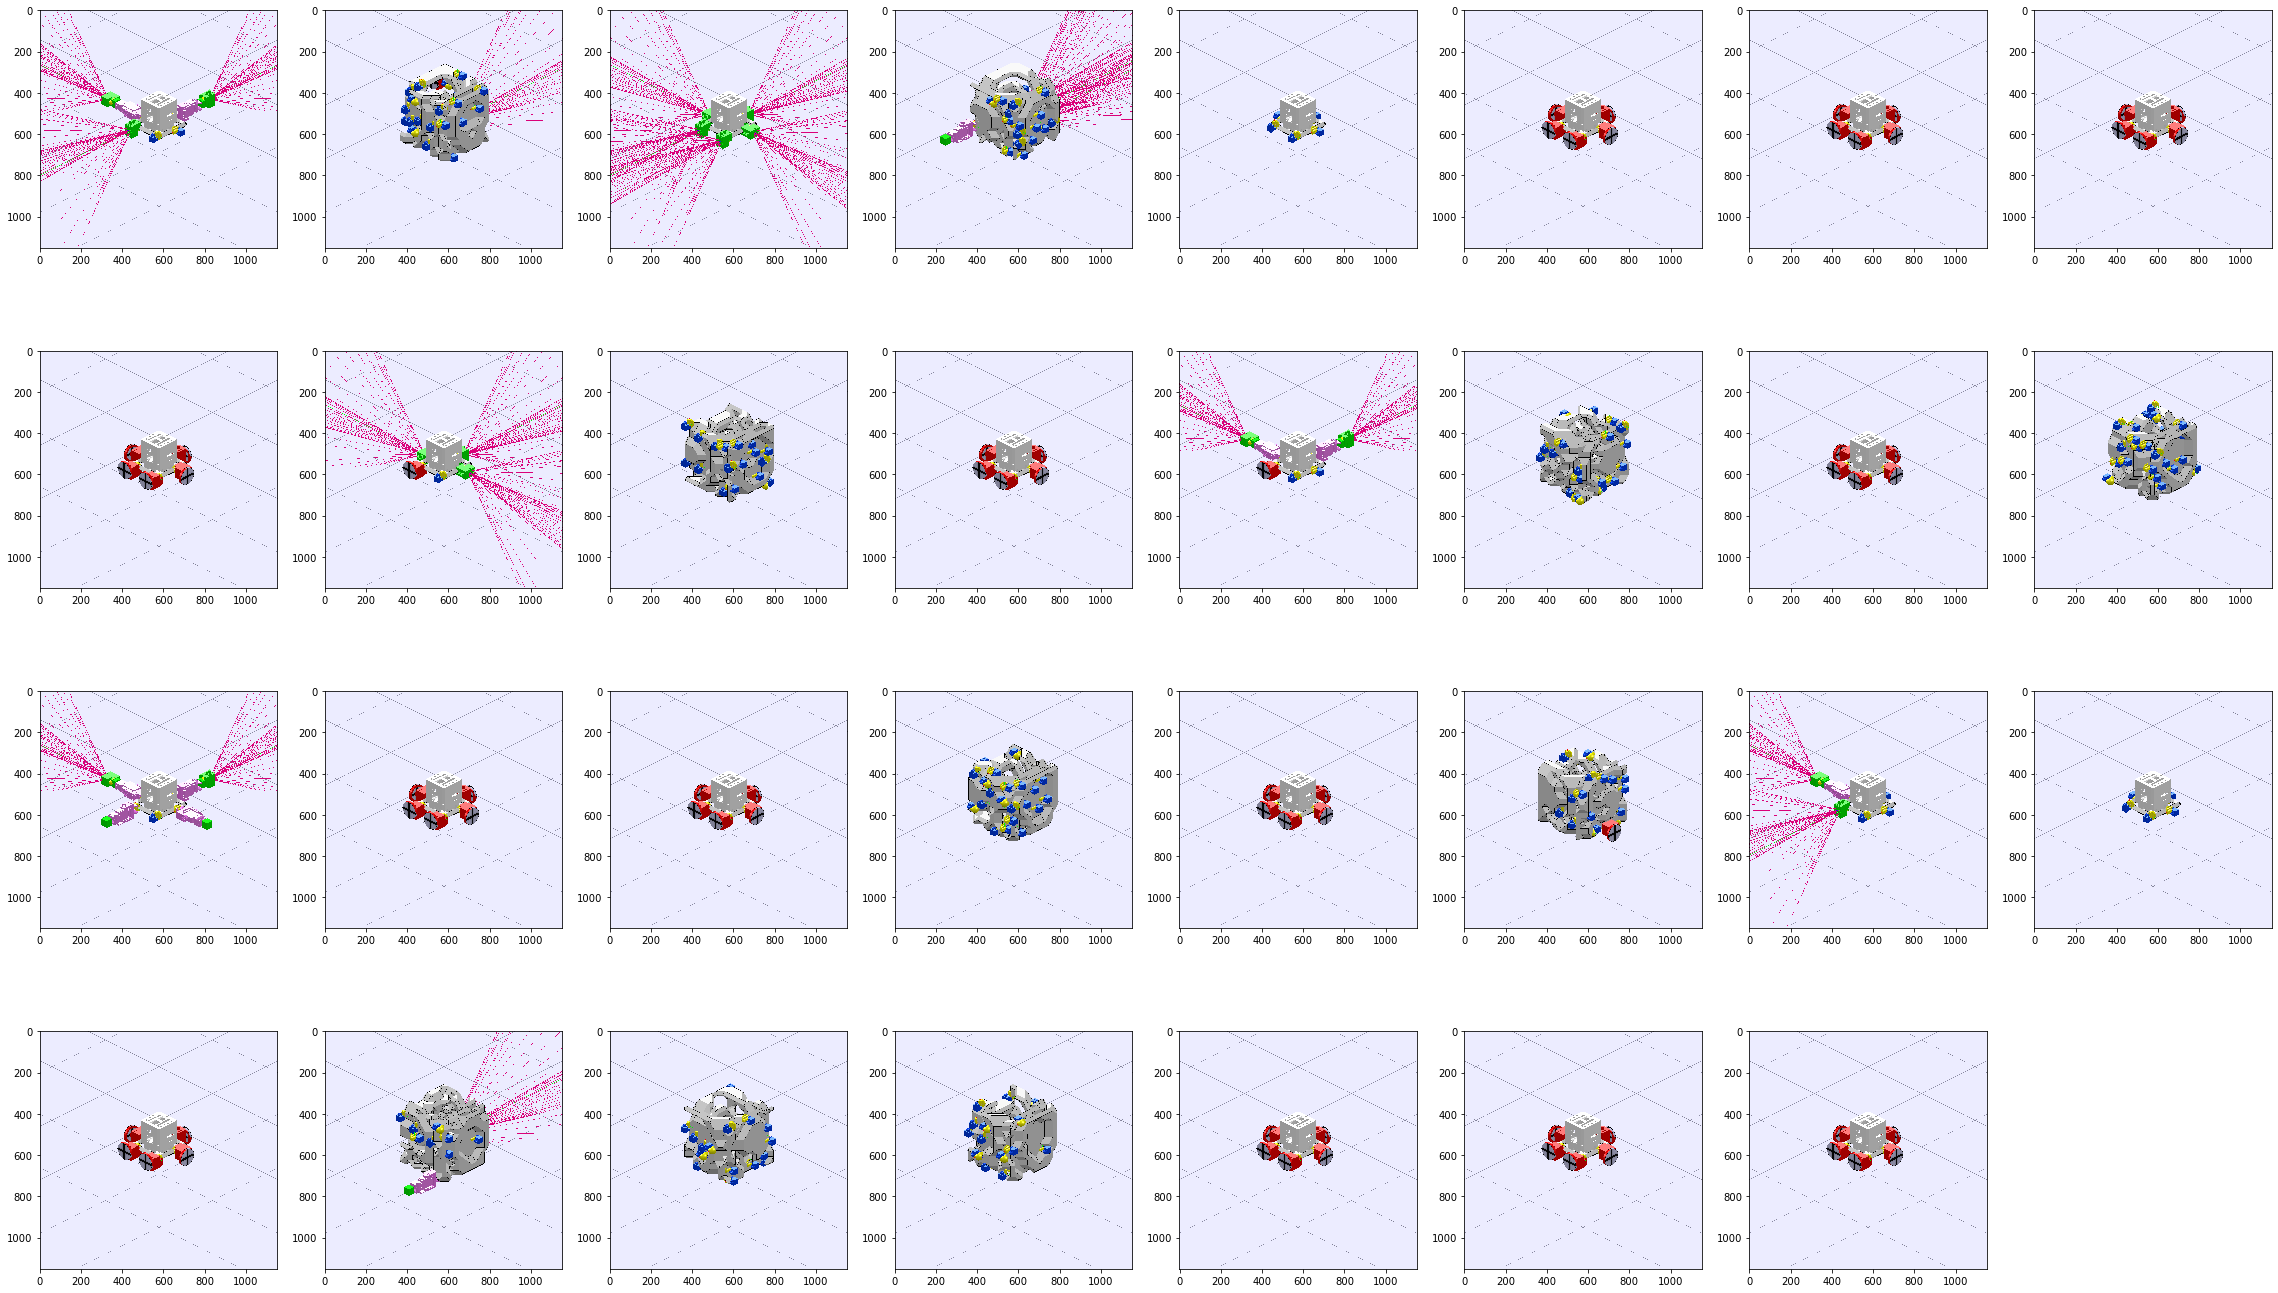

In [270]:
id = 69
print(offsprings[id])
print([id_to_gen_index[o] for o in offsprings[id]])
print([nbr_conn_neur[o] for o in offsprings[id]])
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
off_spars = {spars[0]: spars[1:] for spars in sparsness}
print(off_spars[id])
images = []
image_name = "robot_" + str(id_to_gen_index[id][0]) + "_" + str(id_to_gen_index[id][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
images.append(img)
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
    images.append(img)

columns = 8
height = int(len(images)/columns) * 8
plt.figure(figsize=(40, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[2100, 1746, 1535, 1328, 132, 78]
[[11, 24], [9, 7], [8, 31], [7, 12], [1, 85], [0, 78]]
[[15, 60], [15, 60], [15, 60], [14, 59], [14, 59], [14, 59]]


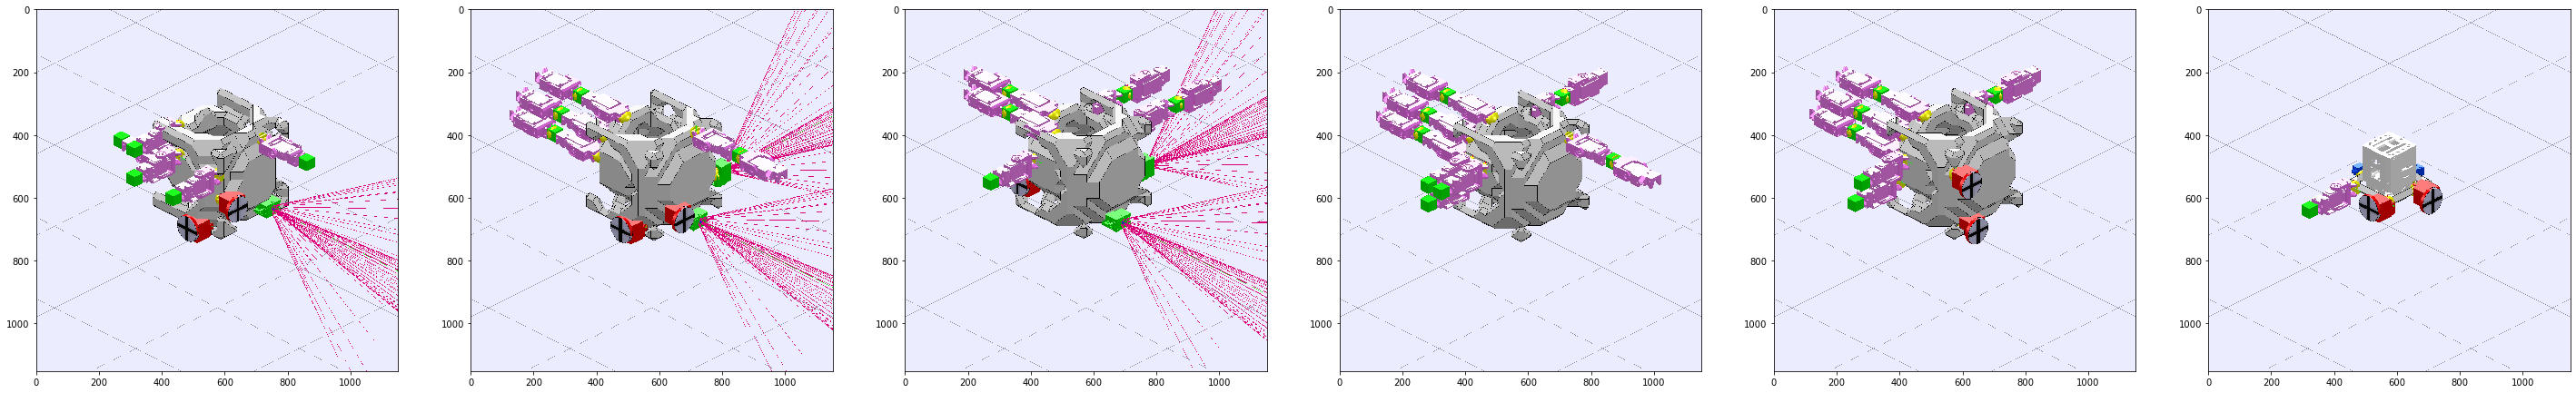

In [18]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/parenting.csv",2100,100)
nb_con_neu = load_nbr_con_neu(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/nbr_conn_neu.csv")
nbr_conn_neur = dict()
for ncn in nb_con_neu:
    nbr_conn_neur[ncn[0]] = ncn[1:]
print(lineage)
print([id_to_gen_index[l] for l in lineage])
print([nbr_conn_neur[l] for l in lineage])
images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)


{'0': Text(-0.45714285714285713, 0.6000000000000001, 'i_0'),
 '1': Text(-0.45714285714285713, 0.2, 'i_1'),
 '2': Text(-0.45714285714285713, -0.2, 'i_2'),
 '3': Text(-0.45714285714285713, -0.6000000000000001, 'i_3'),
 '4': Text(0.3428571428571429, 1.0, 'o_4'),
 '5': Text(0.3428571428571429, 0.6000000000000001, 'o_5'),
 '6': Text(0.3428571428571429, 0.2, 'o_6'),
 '7': Text(0.3428571428571429, -0.2, 'o_7'),
 '8': Text(0.3428571428571429, -0.6000000000000001, 'o_8'),
 '9': Text(0.3428571428571429, -1.0, 'o_9'),
 '10': Text(-0.12380952380952381, 0.6000000000000001, 'sin_0.7312_0.715864'),
 '11': Text(-0.09047619047619049, 0.2, 'lin_0.678195_0.800882'),
 '12': Text(-0.057142857142857106, -0.2, 'gaus_0.657177_0.861929'),
 '13': Text(-0.02380952380952378, -0.6000000000000001, 'sigm_0.217897_0.0830342')}

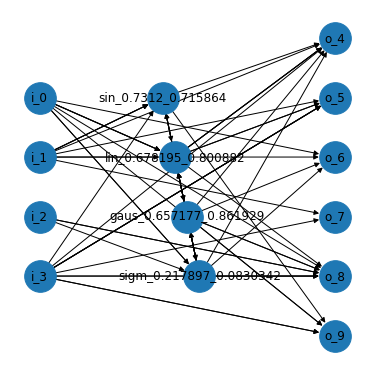

In [300]:
g = netx.nx_agraph.read_dot(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/morph_genome_78.dot")
for k in g.nodes:
    g.nodes[k]['layer'] = int(g.nodes[k]['layer'])
edge_labels = netx.get_edge_attributes(g,'label')
node_labels = netx.get_node_attributes(g,'label')
pos = netx.layout.multipartite_layout(g,subset_key='layer')
for k, p in pos.items():
    if(int(k) > 9):
        p[0,] = pos['0'][0,] + int(k)/30.
plt.figure(figsize=(5,5))
netx.draw(g,pos=pos,node_size=1000)
netx.draw_networkx_labels(g,pos,node_labels)

{'0': Text(-0.45714285714285713, 0.6000000000000001, 'i_0'),
 '1': Text(-0.45714285714285713, 0.2, 'i_1'),
 '2': Text(-0.45714285714285713, -0.2, 'i_2'),
 '3': Text(-0.45714285714285713, -0.6000000000000001, 'i_3'),
 '4': Text(0.3428571428571429, 1.0, 'o_4'),
 '5': Text(0.3428571428571429, 0.6000000000000001, 'o_5'),
 '6': Text(0.3428571428571429, 0.2, 'o_6'),
 '7': Text(0.3428571428571429, -0.2, 'o_7'),
 '8': Text(0.3428571428571429, -0.6000000000000001, 'o_8'),
 '9': Text(0.3428571428571429, -1.0, 'o_9'),
 '10': Text(-0.12380952380952381, 0.6000000000000001, 'sin_0.7312_0.722046'),
 '11': Text(-0.09047619047619049, 0.2, 'lin_0.678195_0.800882'),
 '12': Text(-0.057142857142857106, -0.2, 'gaus_0.657177_0.861929'),
 '13': Text(-0.02380952380952378, -0.6000000000000001, 'sigm_0.217897_0.0376526')}

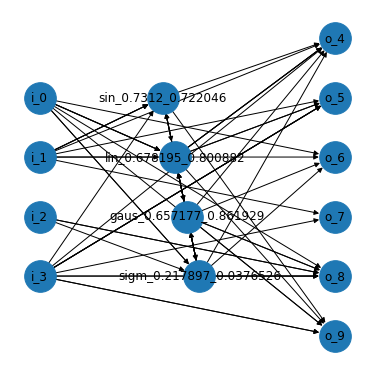

In [301]:
g = netx.nx_agraph.read_dot(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/morph_genome_132.dot")
for k in g.nodes:
    g.nodes[k]['layer'] = int(g.nodes[k]['layer'])
edge_labels = netx.get_edge_attributes(g,'label')
node_labels = netx.get_node_attributes(g,'label')
pos = netx.layout.multipartite_layout(g,subset_key='layer')
for k, p in pos.items():
    if(int(k) > 9):
        p[0,] = pos['0'][0,] + int(k)/30.
plt.figure(figsize=(5,5))
netx.draw(g,pos=pos,node_size=1000)
netx.draw_networkx_labels(g,pos,node_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [0, 33], [0, 34], [0, 35], [0, 36], [0, 37], [0, 38], [0, 39], [0, 40], [0, 41], [0, 42], [0, 43], [0, 44], [0, 45], [0, 46], [0, 47], [0, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [0, 54], [0, 55], [0, 56], [0, 57], [0, 58], [0, 59], [0, 60], [0, 61], [0, 62], [0, 63], [0, 64], [0, 65], [0, 66], [0, 67], [0, 68

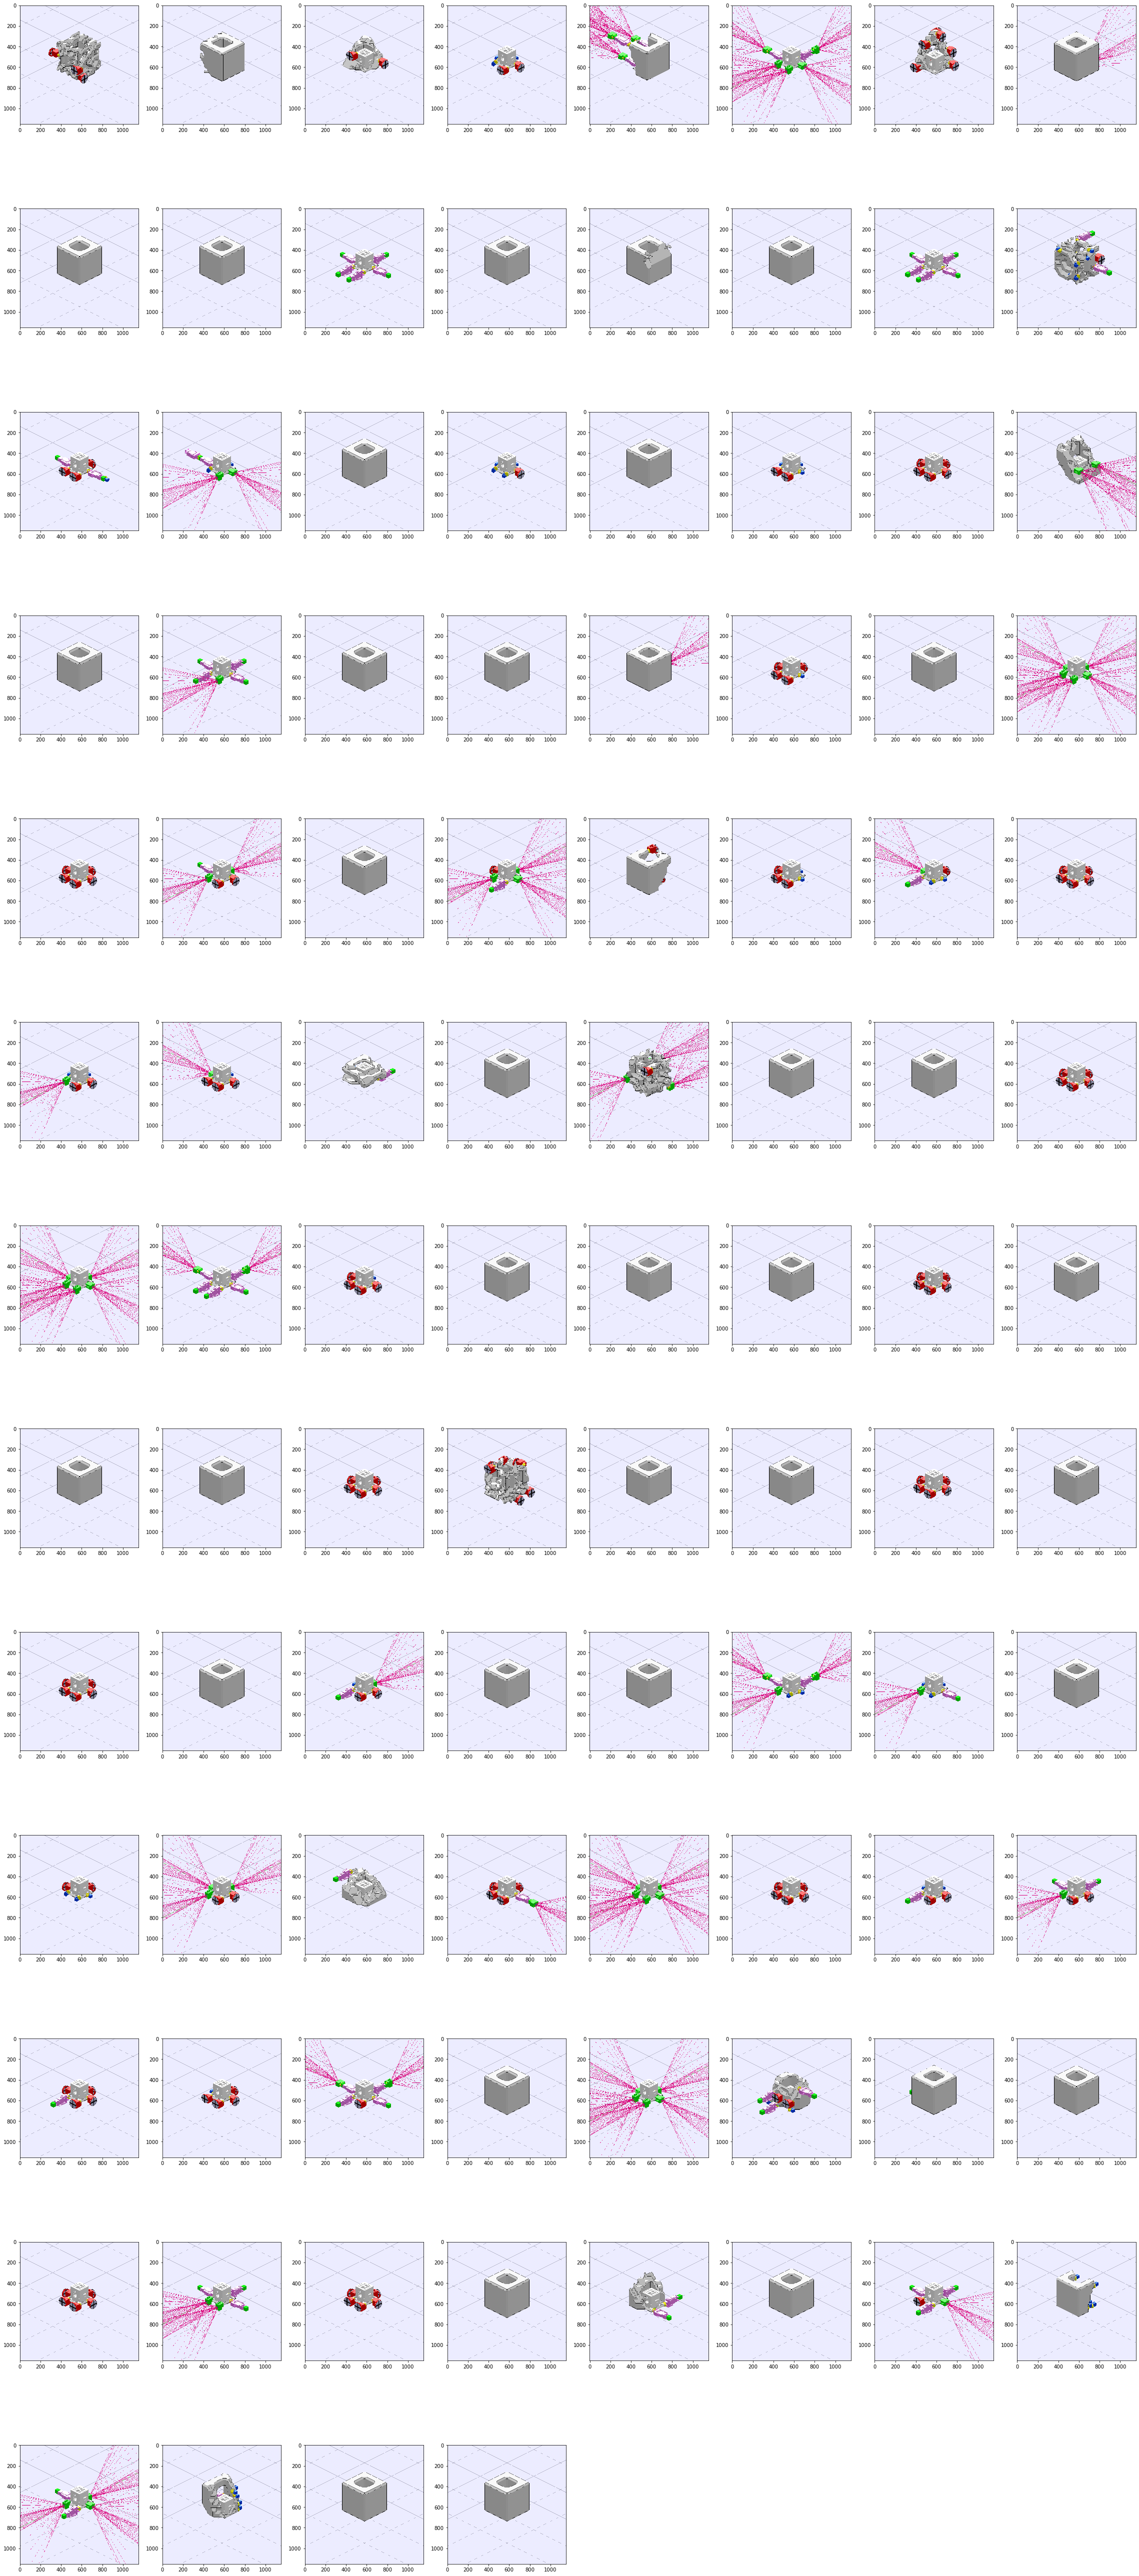

In [125]:
id = -1
print(offsprings[id])
print([id_to_gen_index[o] for o in offsprings[id]])
print([nbr_conn_neur[o] for o in offsprings[id]])
images = []
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
    images.append(img)
columns = 8
height = int(len(images)/columns) * 8
plt.figure(figsize=(40, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[170, 176, 306]
[[1, 8], [1, 21], [2, 86]]
[[25, 655], [22, 584], [24, 261]]


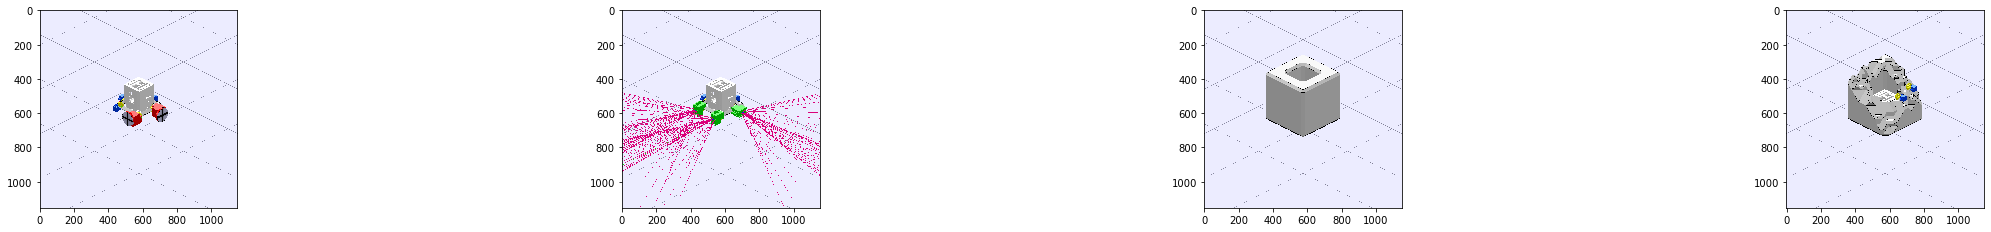

In [126]:
id = 3
print(offsprings[id])
print([id_to_gen_index[o] for o in offsprings[id]])
print([nbr_conn_neur[o] for o in offsprings[id]])
images = []
image_name = "robot_" + str(id_to_gen_index[id][0]) + "_" + str(id_to_gen_index[id][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
images.append(img)
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_24_8_14-25-1-1049-51983/images/" + image_name)
    images.append(img)
columns = 4
height = int(len(images)/columns) * 8
plt.figure(figsize=(40, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [245]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_onlyparammut01/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

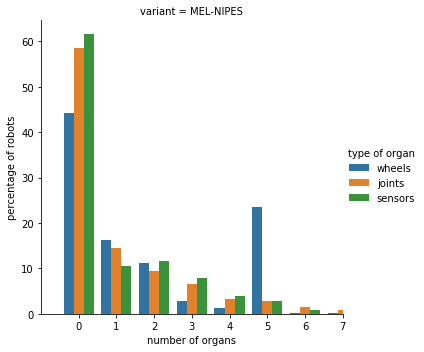

In [87]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

(array([0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75]),
 <a list of 9 Text yticklabel objects>)

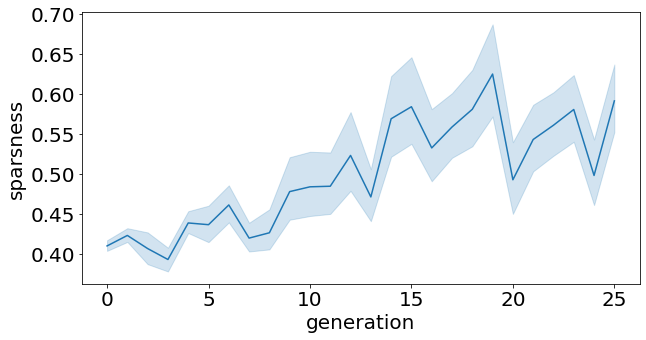

In [90]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_4_9_14-36-38-8441-509850233/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text yticklabel objects>)

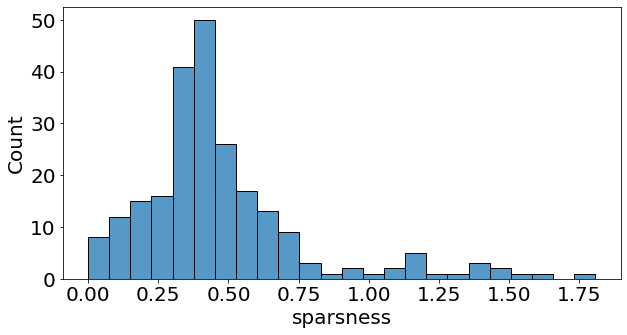

In [246]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_4_9_14-36-38-8441-509850233/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_4_9_14-36-38-8441-509850233/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.histplot(data=data,x="sparsness")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [89]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_4_9_14-36-38-8441-509850233


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 <a list of 8 Text yticklabel objects>)

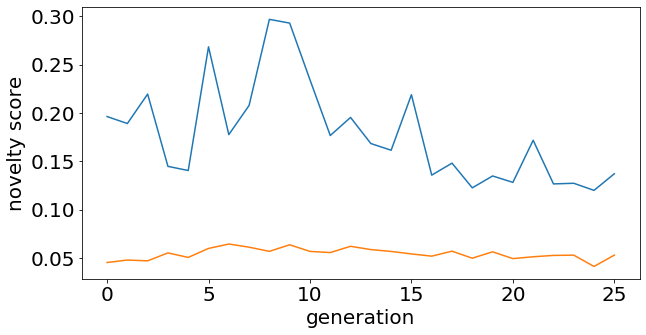

In [28]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [76]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_4_9_14-36-38-8441-509850233


(array([14., 15., 16., 17., 18., 19., 20.]),
 <a list of 7 Text yticklabel objects>)

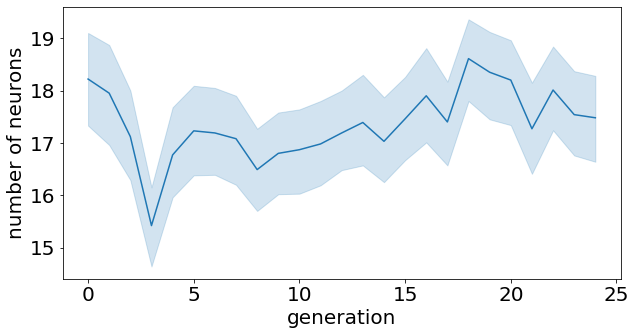

In [77]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")
ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([300., 350., 400., 450., 500., 550., 600.]),
 <a list of 7 Text yticklabel objects>)

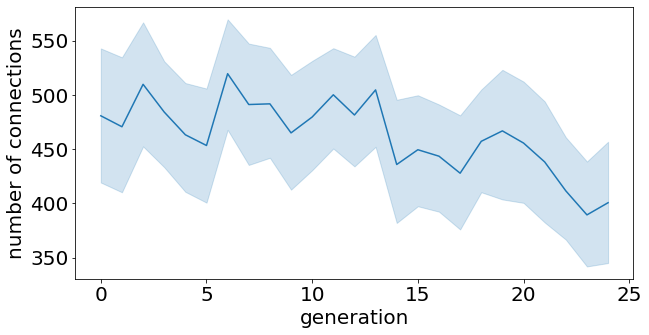

In [78]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")
ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

[4975, 1320, 78]
[[25, 81], [7, 26], [0, 78]]


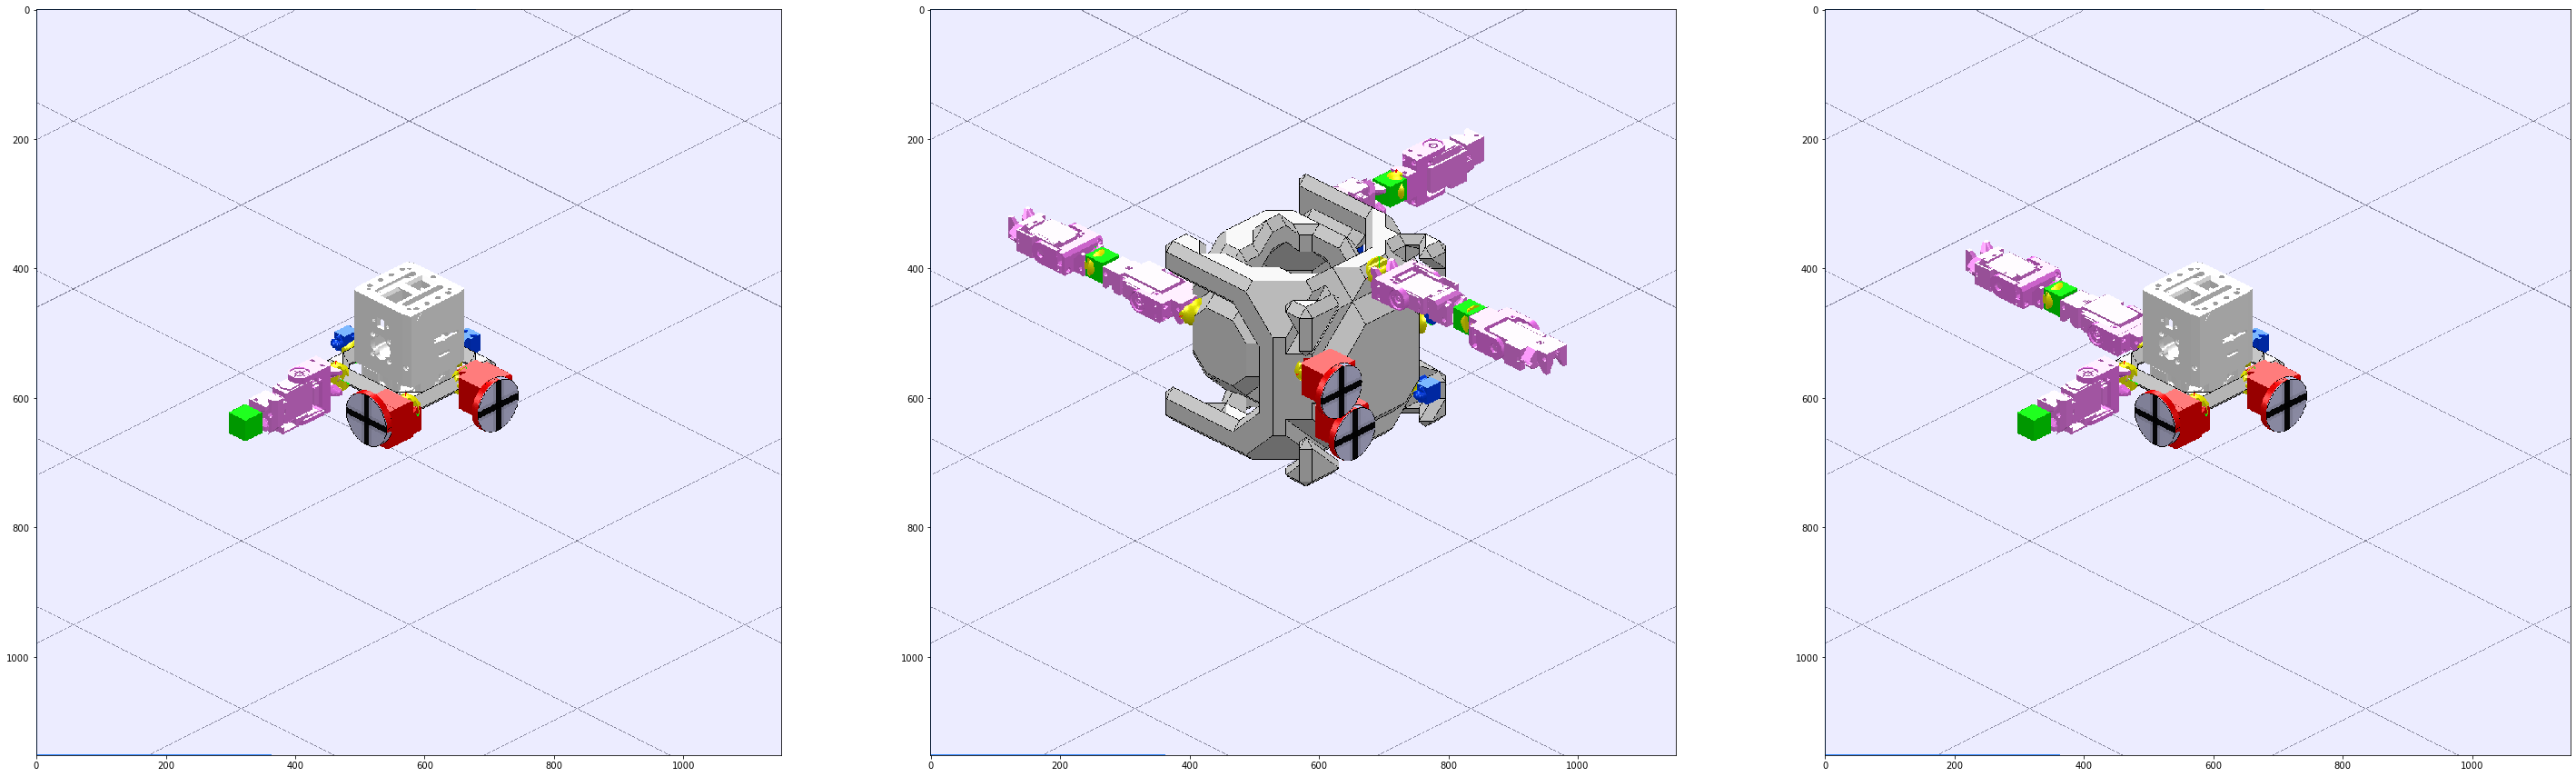

In [33]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_4_9_14-36-38-8441-509850233/parenting.csv",4975,100)
print(lineage)
print([id_to_gen_index[l] for l in lineage])
images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_4_9_14-36-38-8441-509850233/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[105, 358, 304, 570, 549, 932, 926, 1320, 1538]


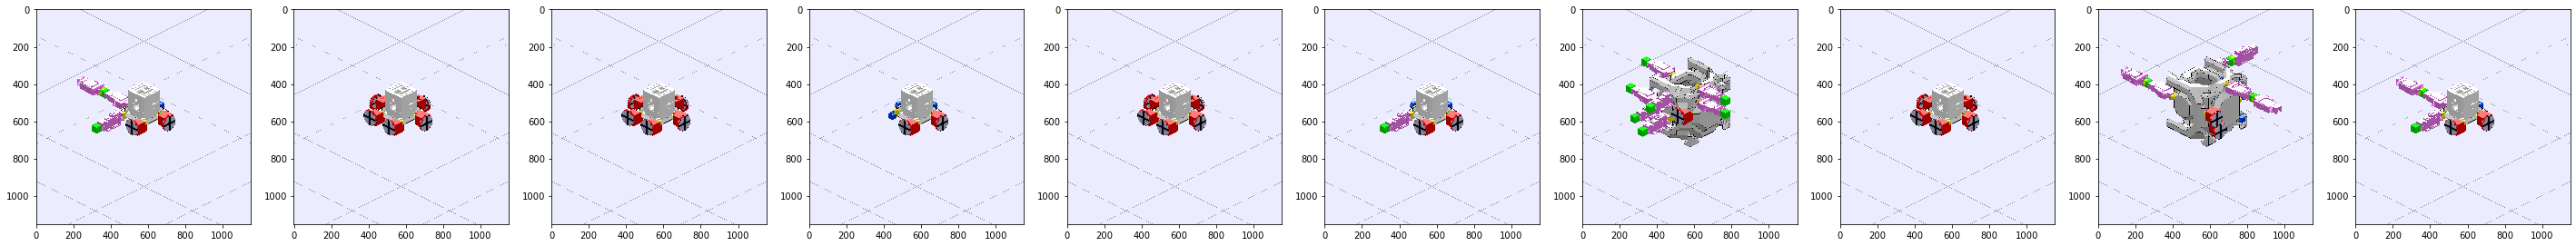

In [38]:
print(offsprings[78])
images = []
image_name = "robot_" + str(id_to_gen_index[78][0]) + "_" + str(id_to_gen_index[78][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_4_9_14-36-38-8441-509850233/images/" + image_name)
images.append(img)
for o in offsprings[78]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_4_9_14-36-38-8441-509850233/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [91]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_afmutonly/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

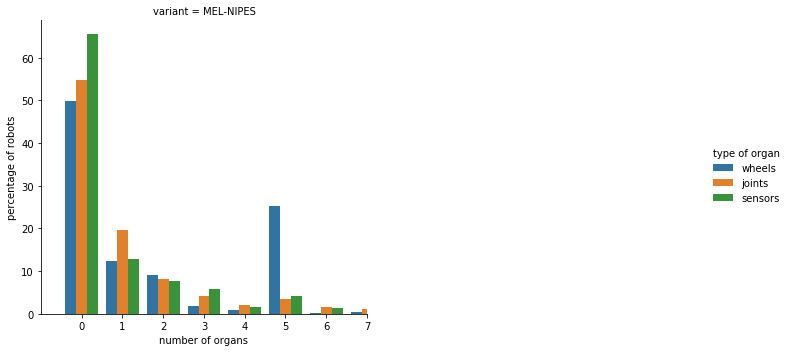

In [92]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

(array([0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75]),
 <a list of 9 Text yticklabel objects>)

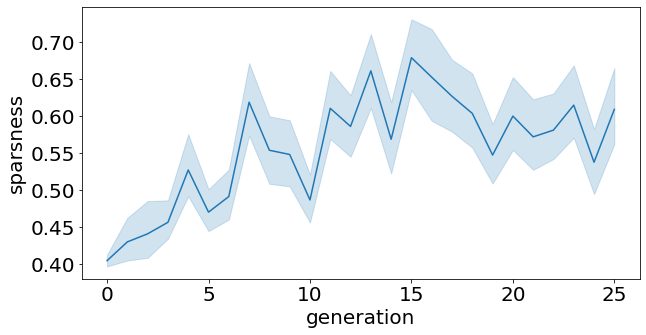

In [94]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [93]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_5_9_11-6-35-5793-3310856281


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

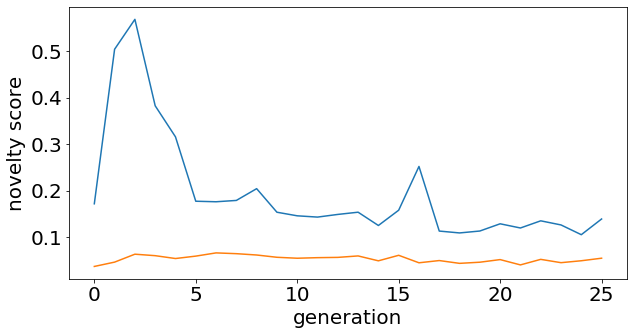

In [42]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [43]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_5_9_11-6-35-5793-3310856281


(array([15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5]),
 <a list of 9 Text yticklabel objects>)

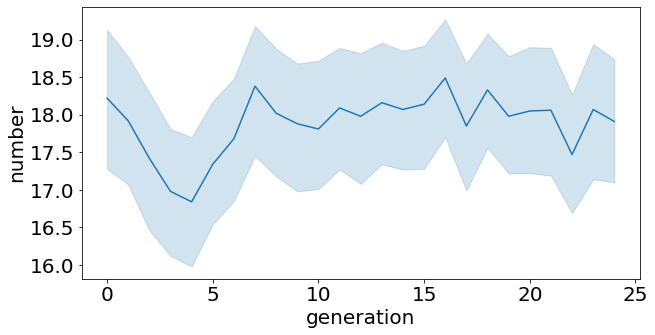

In [44]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")
ax.set_ylabel("number")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([350., 400., 450., 500., 550., 600., 650., 700.]),
 <a list of 8 Text yticklabel objects>)

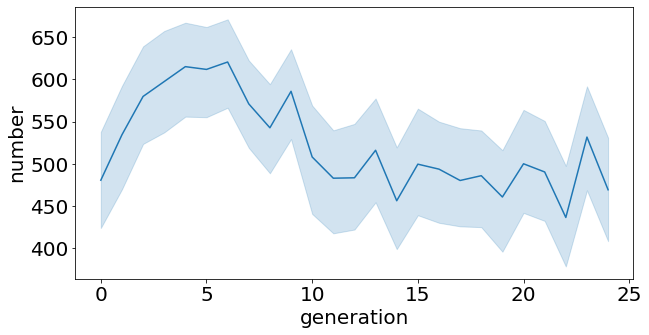

In [45]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")
ax.set_ylabel("number")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

[4994, 1739, 1514, 1140, 903, 104, 78]
[[25, 97], [9, 54], [8, 73], [6, 58], [5, 24], [1, 48], [0, 78]]


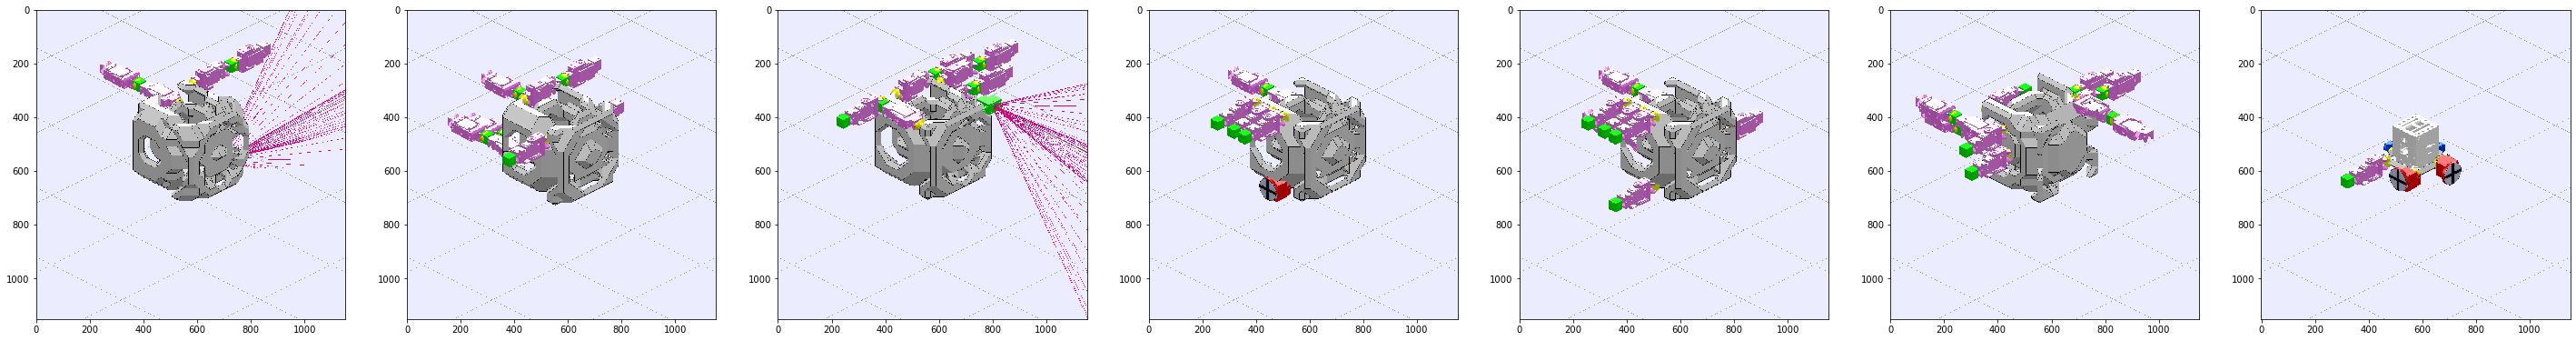

In [50]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/parenting.csv",4994,100)
print(lineage)
print([id_to_gen_index[l] for l in lineage])
images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[104, 102, 321]


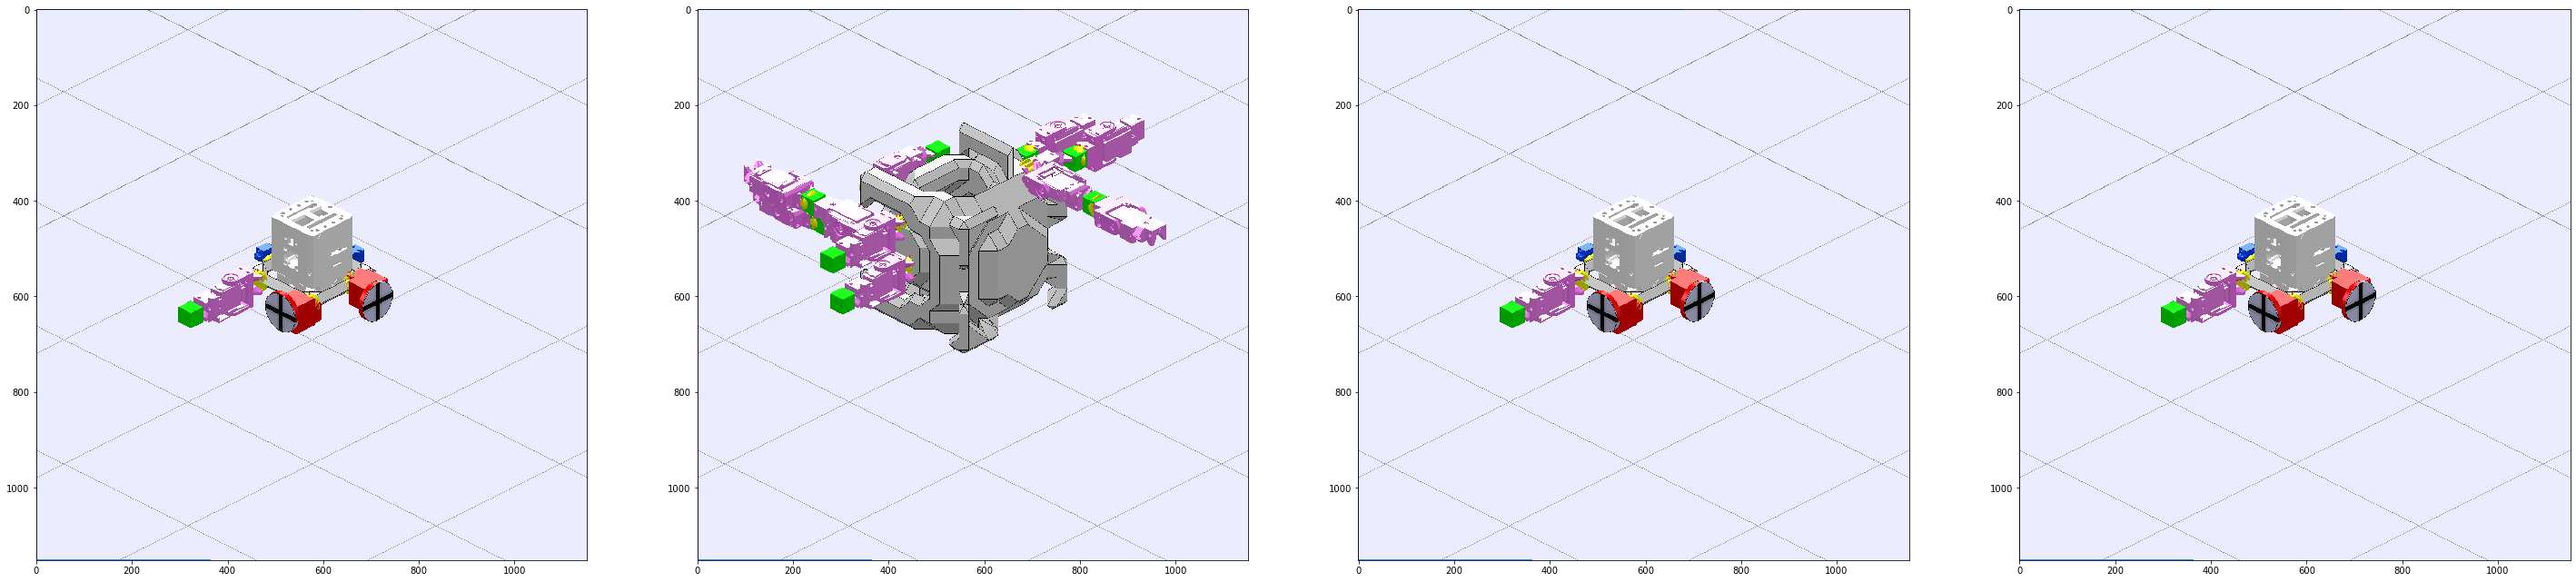

In [51]:
id = 78
print(offsprings[id])
images = []
image_name = "robot_" + str(id_to_gen_index[id][0]) + "_" + str(id_to_gen_index[id][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/images/" + image_name)
images.append(img)
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[4975, 991, 570, 124, 96]
[[25, 10], [5, 47], [3, 22], [1, 64], [0, 96]]


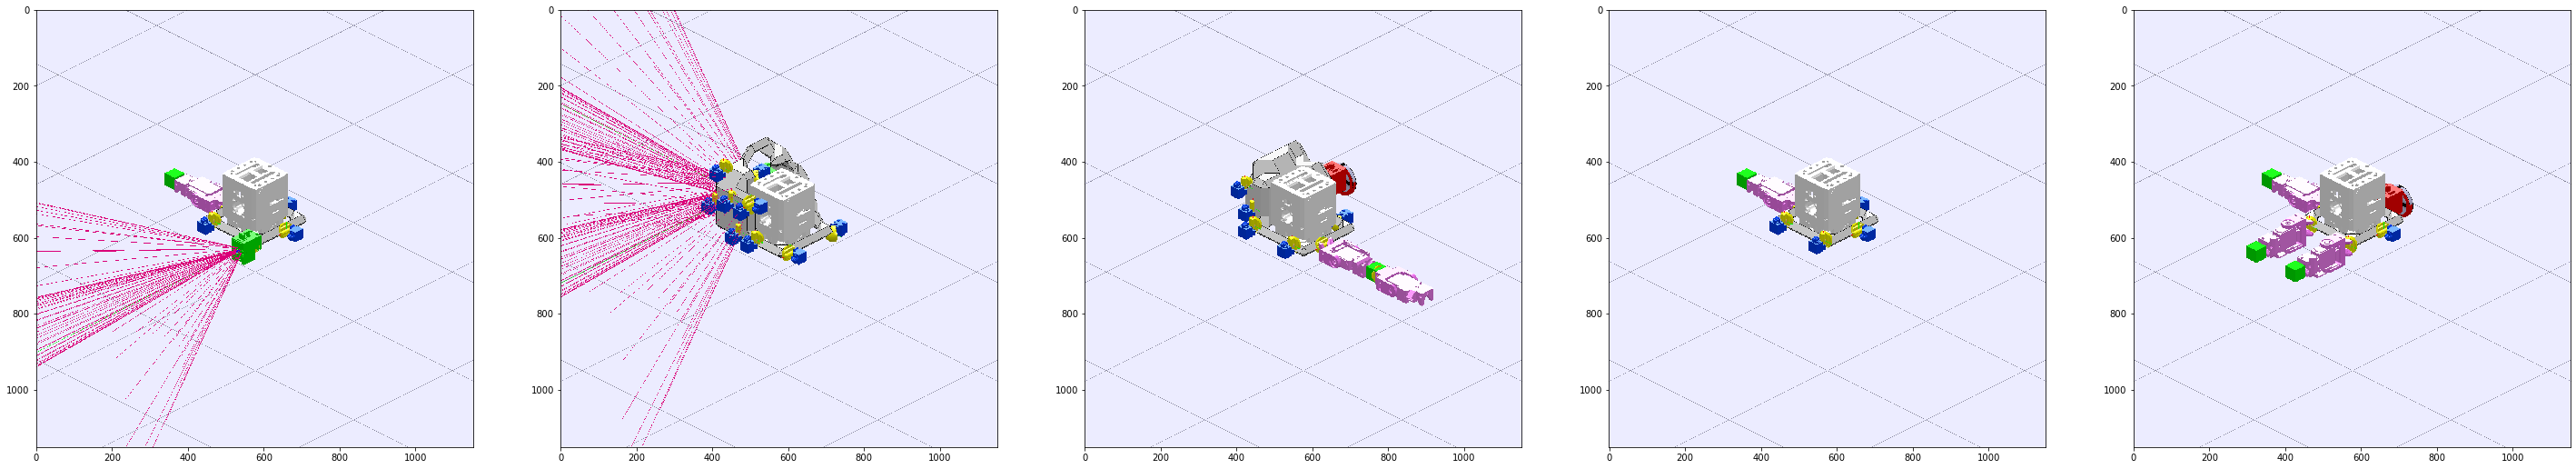

In [81]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/parenting.csv",4975,100)
print(lineage)
print([id_to_gen_index[l] for l in lineage])
images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[744, 764, 732, 912, 922, 991, 931, 936, 1109, 1127, 1185, 1762, 1753, 2132, 2151, 2316, 2372, 2555, 2911, 3146, 3398, 3542, 3519, 3599, 3794, 3992, 4190, 4307, 4728, 4764, 4710, 4966]


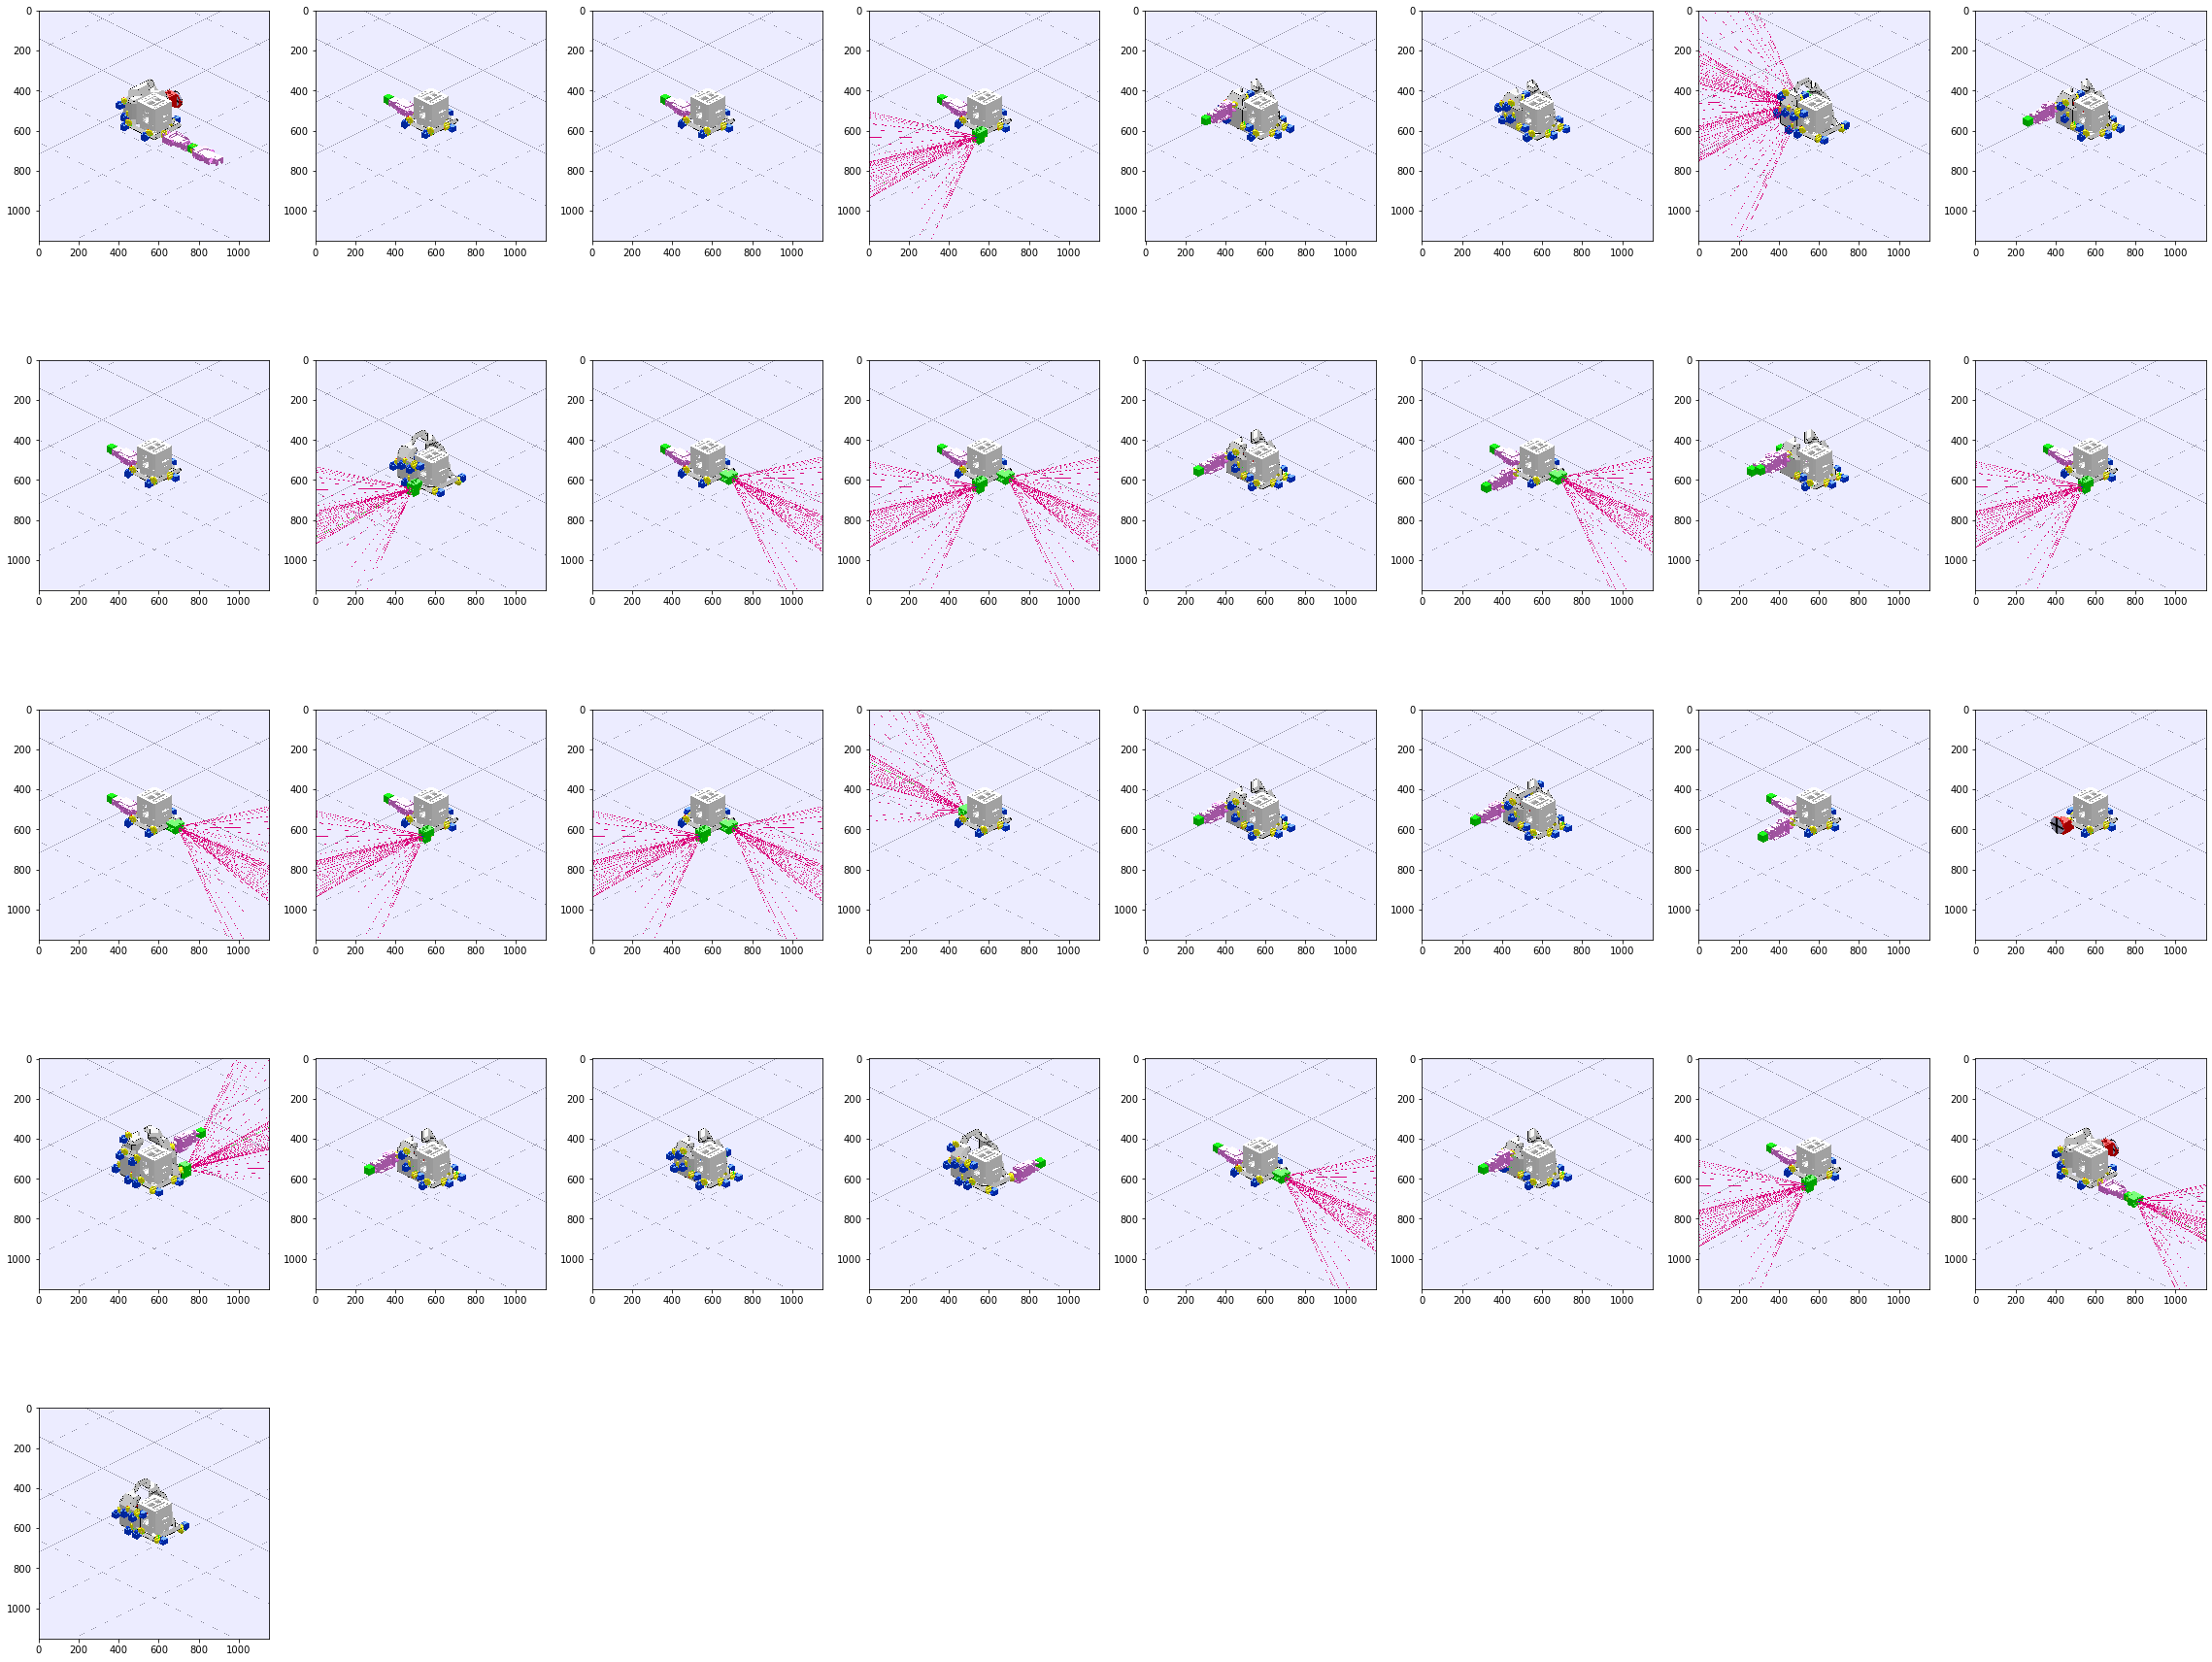

In [83]:
id = 570
print(offsprings[id])
images = []
image_name = "robot_" + str(id_to_gen_index[id][0]) + "_" + str(id_to_gen_index[id][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/images/" + image_name)
images.append(img)
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_11-6-35-5793-3310856281/images/" + image_name)
    images.append(img)

columns = 8
height = int(len(images)/columns) * 8
plt.figure(figsize=(40, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [422]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_weightsmutonly/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

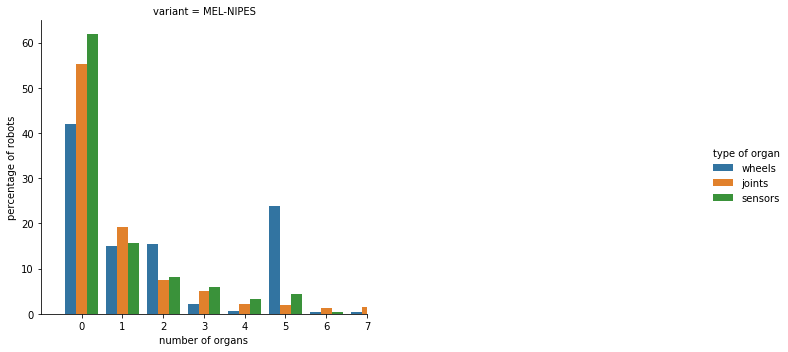

In [96]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=2)
g.set(xlim=[-1,7])

(array([0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ]),
 <a list of 10 Text yticklabel objects>)

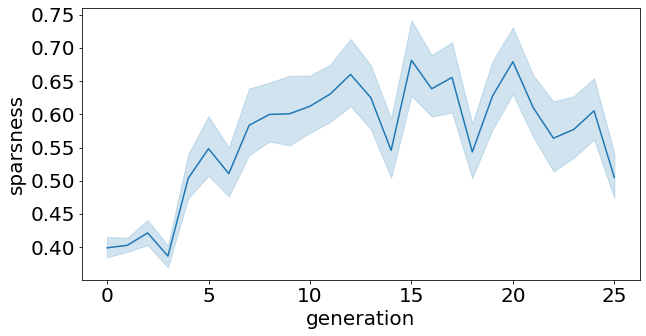

In [98]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [100]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_5_9_15-28-44-4692-2732261255


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text yticklabel objects>)

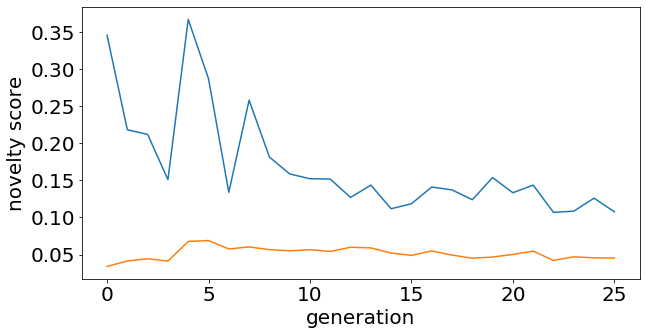

In [101]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [102]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_5_9_15-28-44-4692-2732261255


(array([16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ]),
 <a list of 9 Text yticklabel objects>)

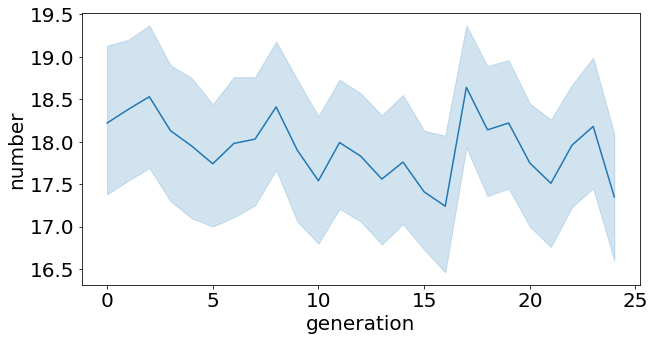

In [103]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")
ax.set_ylabel("number")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([250., 300., 350., 400., 450., 500., 550., 600.]),
 <a list of 8 Text yticklabel objects>)

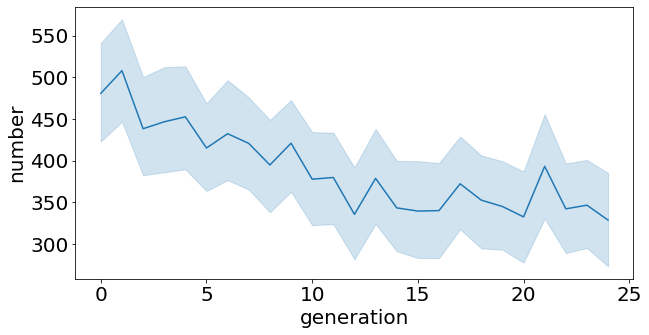

In [104]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")
ax.set_ylabel("number")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

[4970, 138, 40]
[[25, 11], [1, 17], [0, 40]]
[(0, 0, 0, 0.52021), (0, 0, 0, 0.935678), (0, 0, 0, 0.283815), (0, 0, 0, 0.411716), (0, 0, 0, 0.824733), (0, 0, 0, 0.796389), (0, 0, 0, 0.774933), (0, 0, 0, 0.858143), (0, 0, 0, 0.098086), (0, 0, 0, 0.443415), (0, 0, 0, 0.648446), (0, 0, 0, 0.809822), (0, 0, 0, 0.840424), (0, 0, 0, 0.481732), (0, 0, 0, 0.598307), (0, 0, 0, 0.107916), (0, 0, 0, 0.27253), (0, 0, 0, 0.960867), (0, 0, 0, 0.101485), (0, 0, 0, 0.0147324), (0, 0, 0, 0.247884), (0, 0, 0, 0.238841), (0, 0, 0, 0.780606), (0, 0, 0, 0.526431), (0, 0, 0, 0.933665), (0, 0, 0, 0.816779), (0, 0, 0, 0.74266), (0, 0, 0, 0.629363), (0, 0, 0, 0.204278), (0, 0, 0, 0.837198), (0, 0, 0, 0.289039), (0, 0, 0, 0.423868), (0, 0, 0, 0.545922), (0, 0, 0, 0.299806), (0, 0, 0, 0.633995), (0, 0, 0, 0.169475), (0, 0, 0, 0.320067), (0, 0, 0, 0.0321402), (0, 0, 0, 0.90221), (0, 0, 0, 0.370479), (0, 0, 0, 0.520374), (0, 0, 0, 0.0753803), (0, 0, 0, 0.388367), (0, 0, 0, 0.27528), (0, 0, 0, 0.839105), (0, 0, 0, 0

ValueError: RGBA values should be within 0-1 range

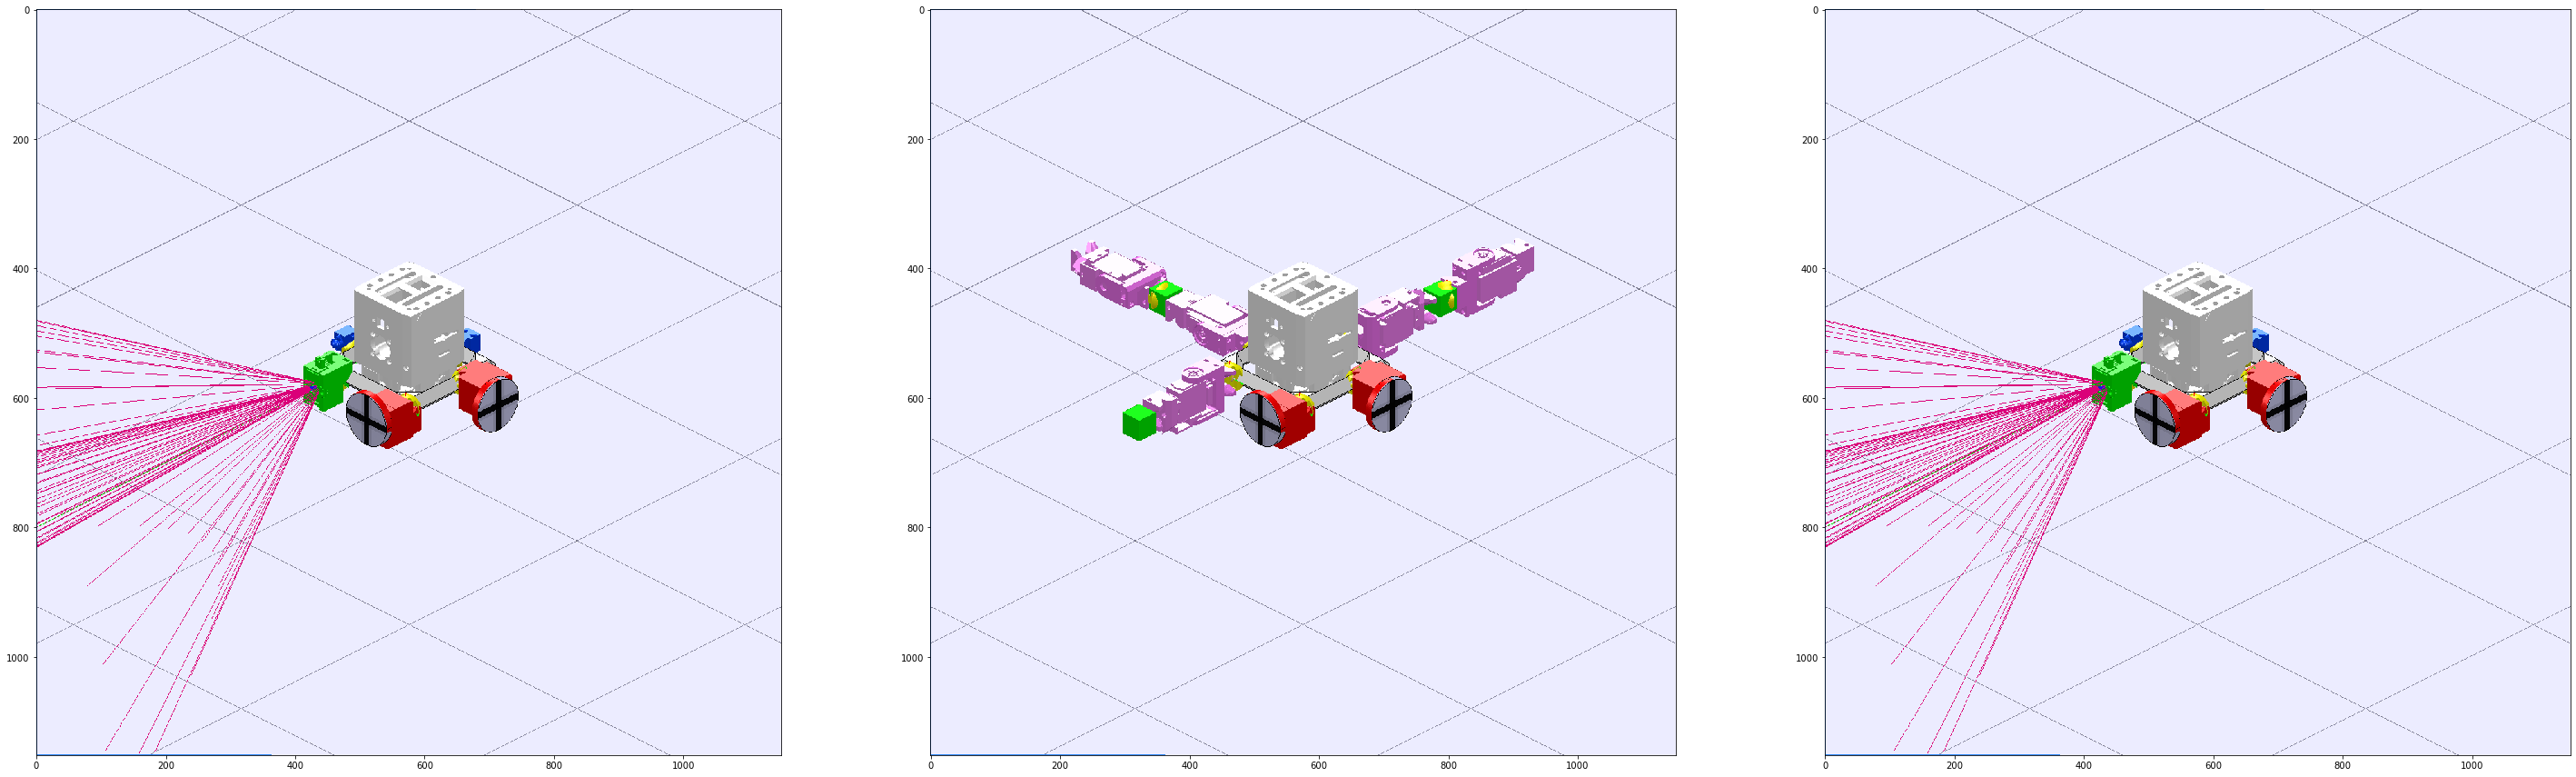

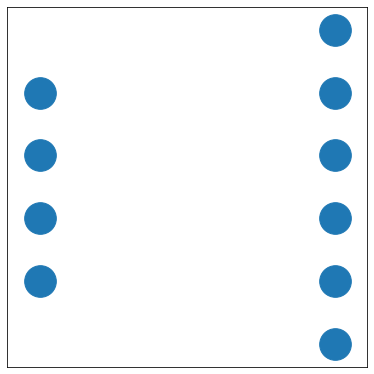

In [426]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/parenting.csv",4970,100)
print(lineage)
print([id_to_gen_index[l] for l in lineage])
images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
draw_cppns(lineage,exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/")

[328, 393, 511, 522, 577, 714, 792, 726, 943, 1108, 1197, 1121, 1586, 1591, 1728, 1799, 1772, 1960, 2106, 2154, 2363, 2397, 2524, 2542, 2583, 2779, 2966, 4173, 4107, 4535, 4594, 4970, 4988]


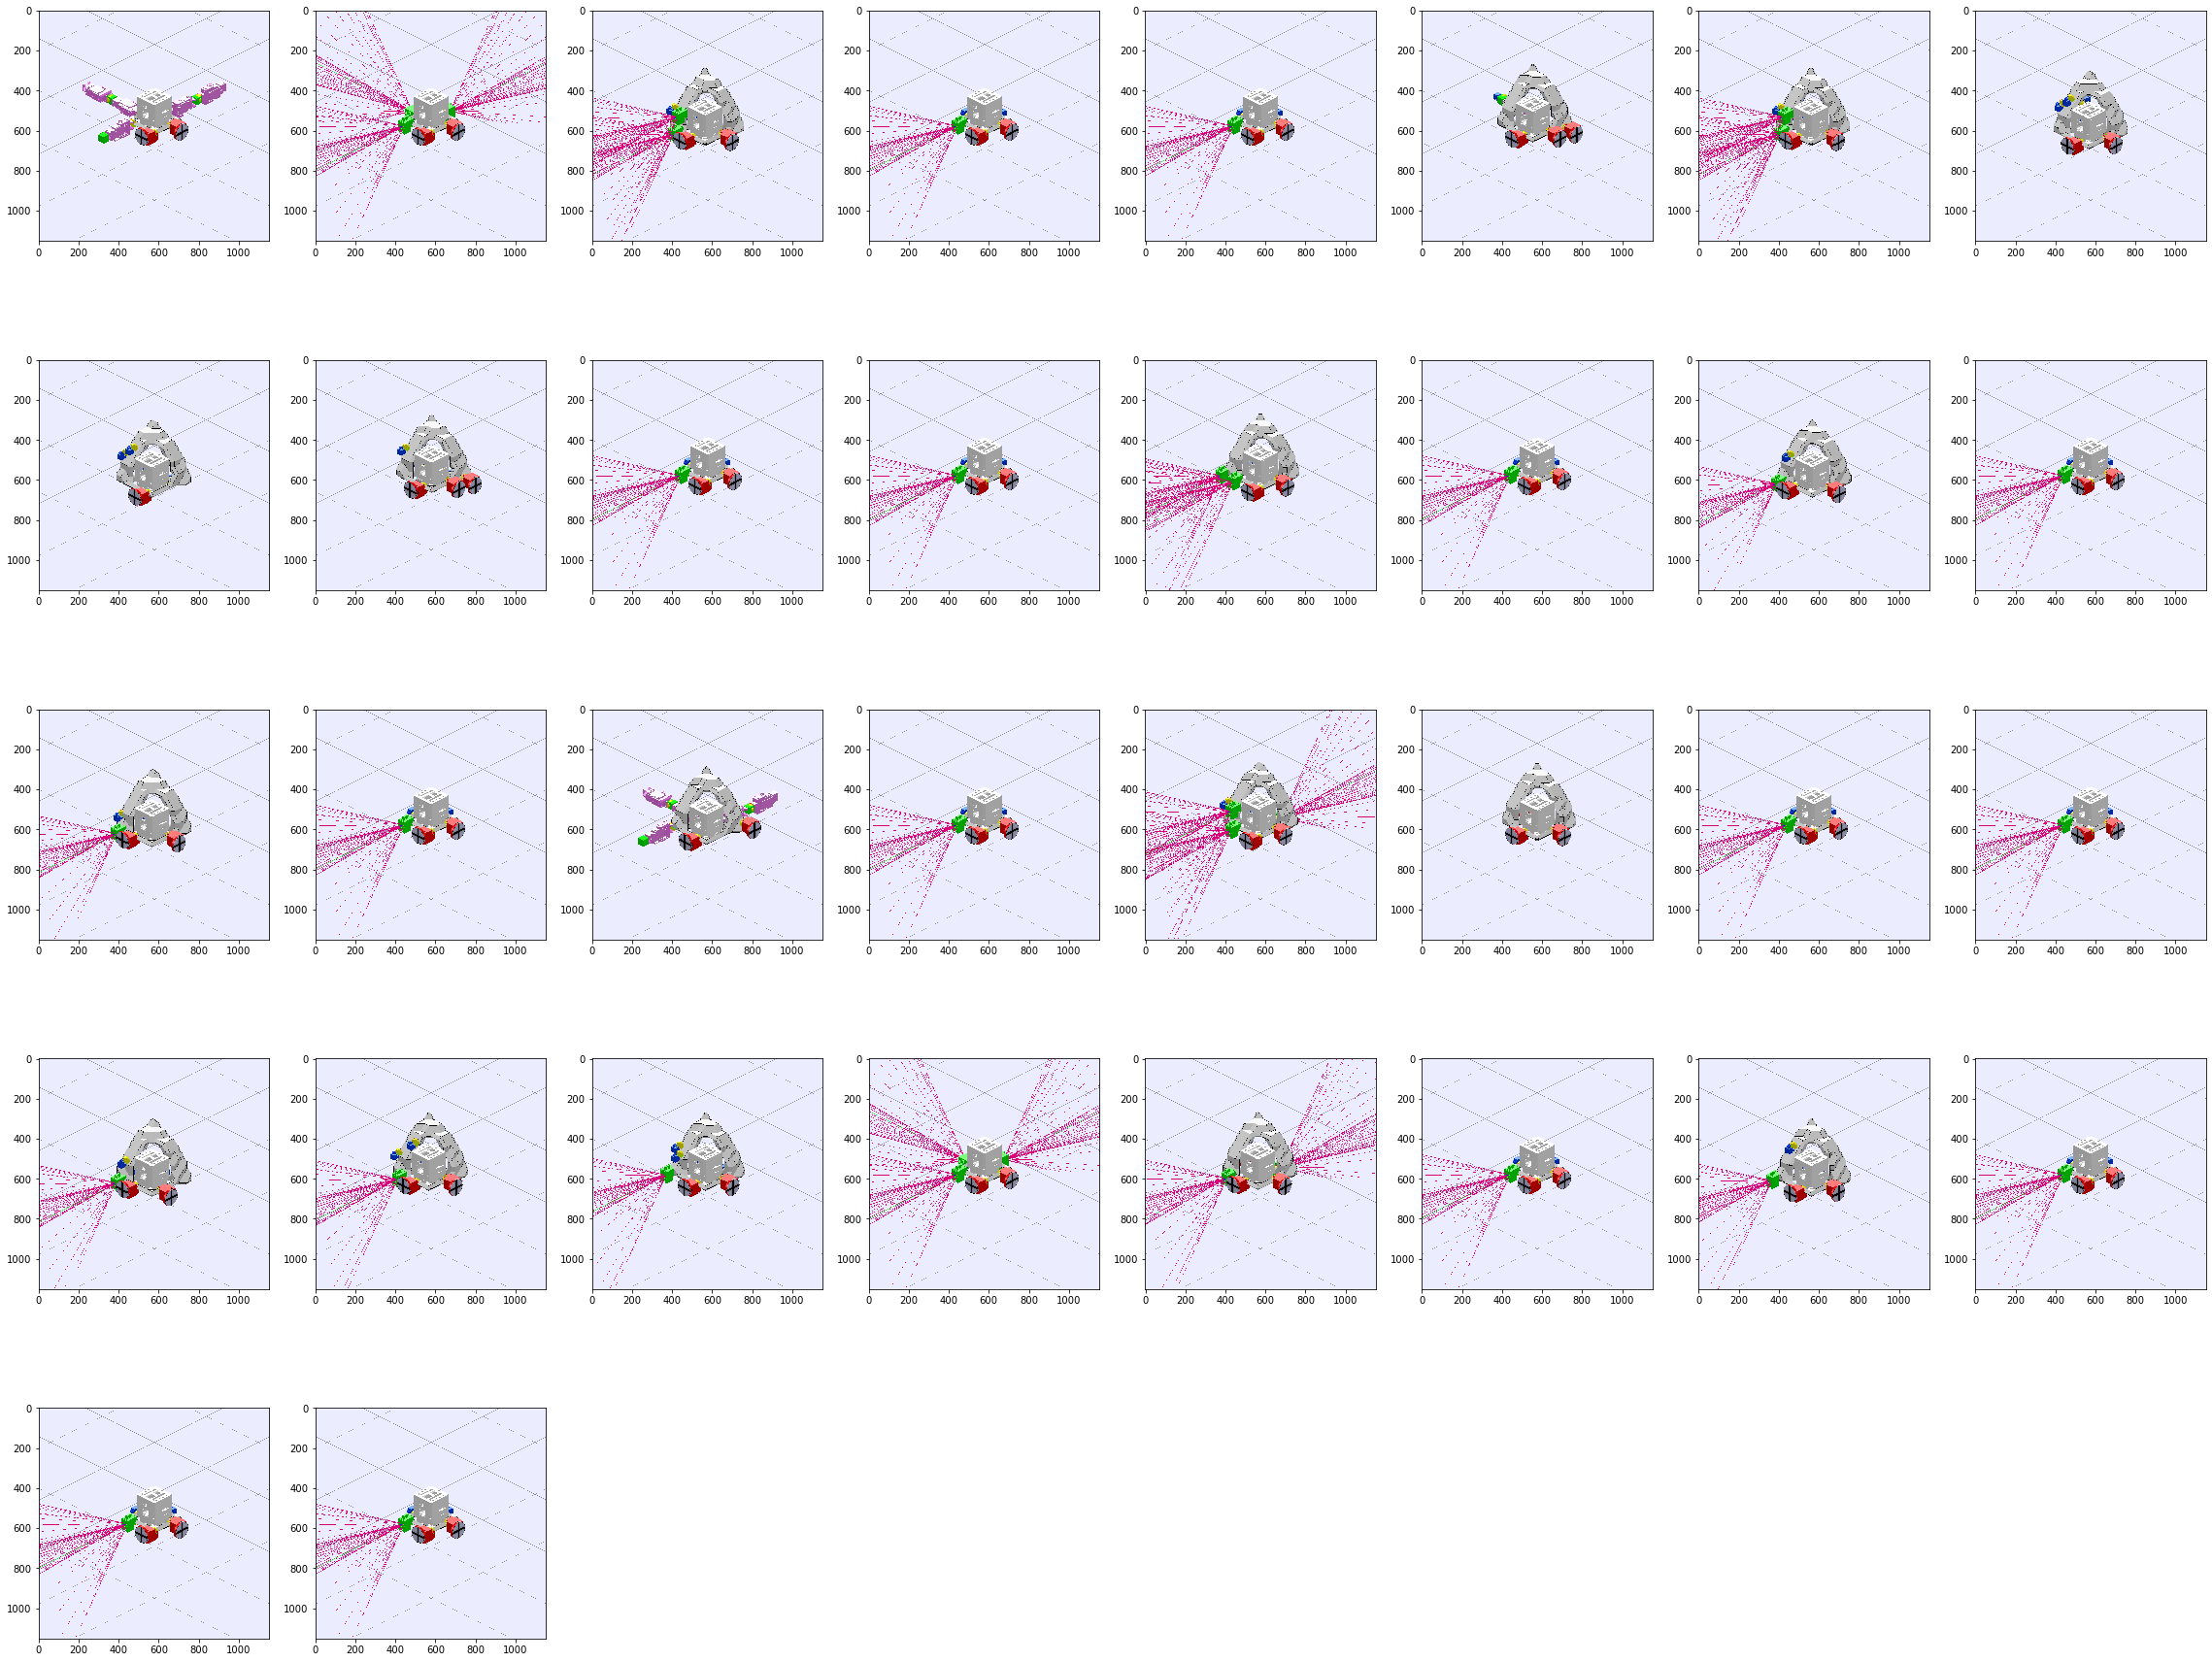

In [118]:
id = 138
print(offsprings[id])
images = []
image_name = "robot_" + str(id_to_gen_index[id][0]) + "_" + str(id_to_gen_index[id][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/images/" + image_name)
images.append(img)
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/images/" + image_name)
    images.append(img)

columns = 8
height = int(len(images)/columns) * 8
plt.figure(figsize=(40, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

[4975, 1702, 1178, 915, 723, 321, 78]
[[25, 80], [9, 0], [6, 36], [5, 73], [4, 5], [2, 91], [0, 78]]


ValueError: RGBA values should be within 0-1 range

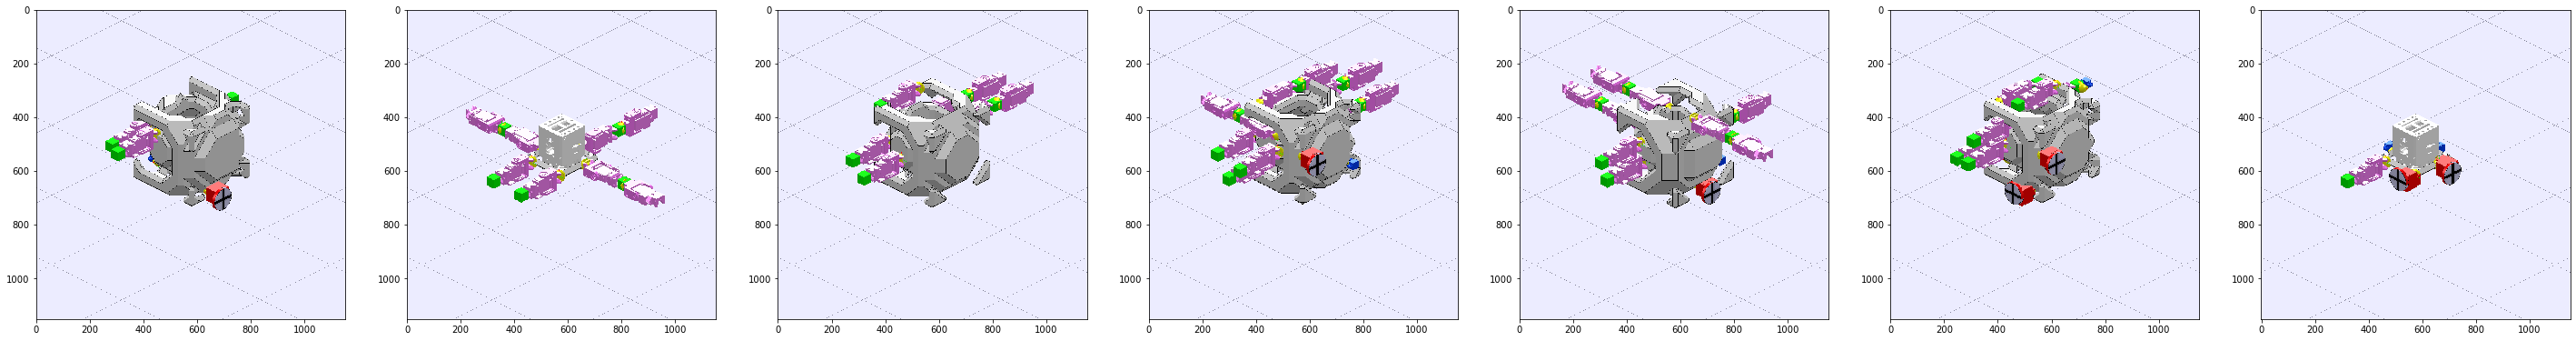

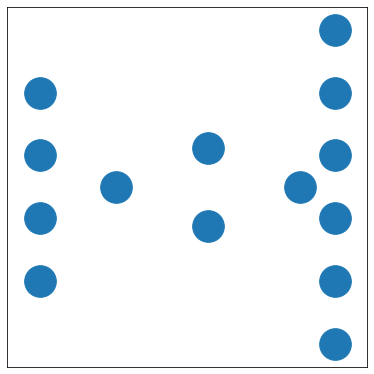

In [424]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/parenting.csv",4975,100)
print(lineage)
print([id_to_gen_index[l] for l in lineage])
images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
draw_cppns(lineage,exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/")

[531, 547, 502, 723, 708, 905, 1118, 1386, 1531, 1504, 1752, 1766, 1913, 1902, 1928, 1975, 1930, 2358, 2324, 2513, 2555, 2581, 2536, 2550, 2597, 2715, 2743, 2723, 2941, 2997, 3180, 3535, 3911, 4195, 4181, 4523, 4553, 4543, 4757, 4933]


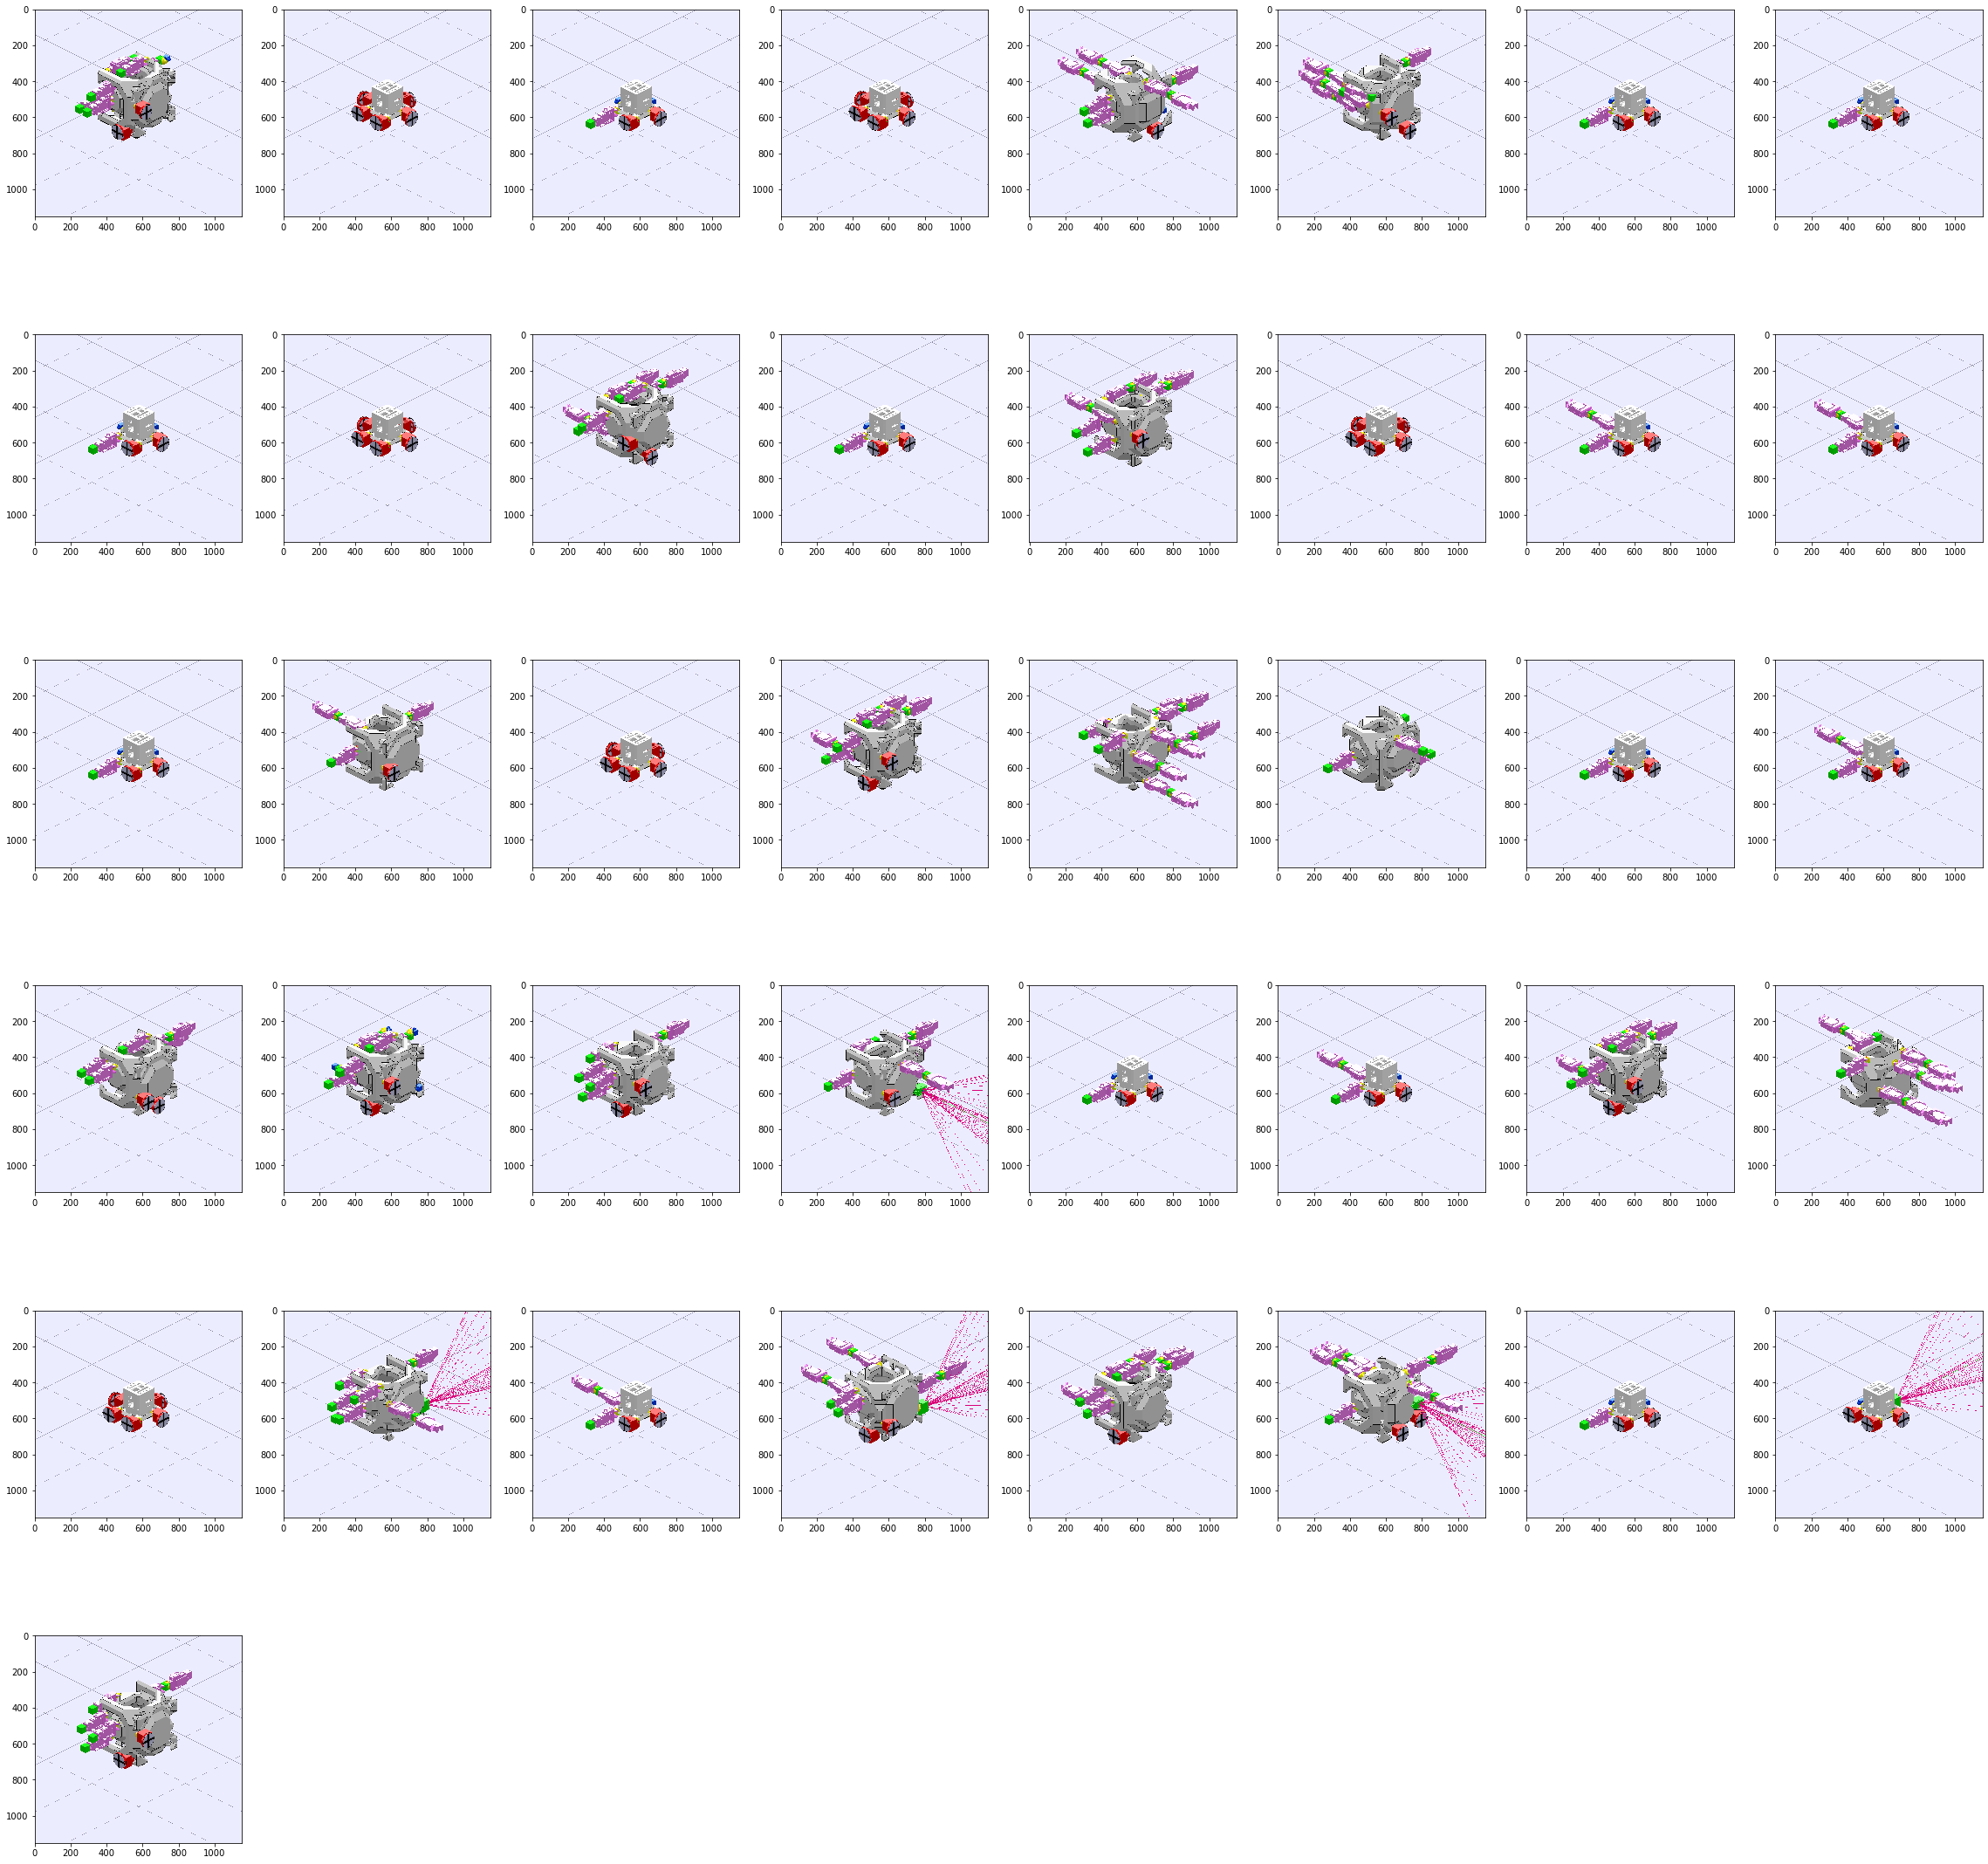

In [122]:
id = 321
print(offsprings[id])
images = []
image_name = "robot_" + str(id_to_gen_index[id][0]) + "_" + str(id_to_gen_index[id][1]) + "_3.png"
img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/images/" + image_name)
images.append(img)
for o in offsprings[id]:
    image_name = "robot_" + str(id_to_gen_index[o][0]) + "_" + str(id_to_gen_index[o][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_5_9_15-28-44-4692-2732261255/images/" + image_name)
    images.append(img)

columns = 8
height = int(len(images)/columns) * 8
plt.figure(figsize=(40, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [3]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_allp01_smallcpnn/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

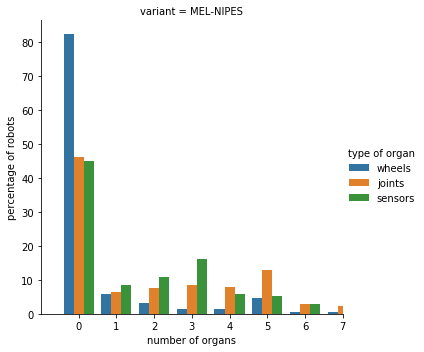

In [4]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [5]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_7_9_11-40-5-5804-2264064849


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

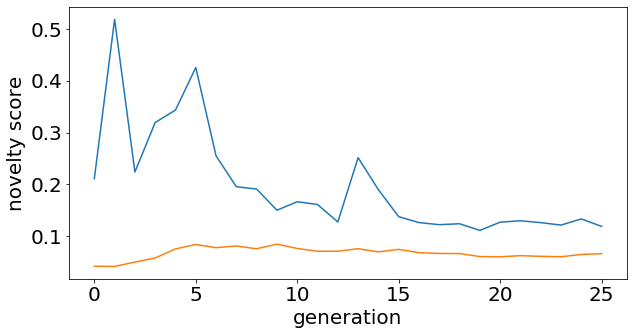

In [6]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [7]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_7_9_11-40-5-5804-2264064849


(array([10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5]),
 <a list of 7 Text yticklabel objects>)

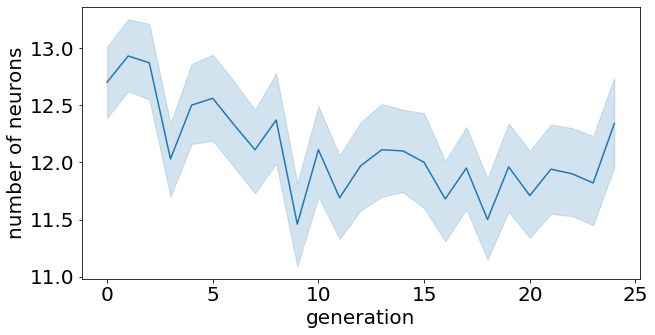

In [309]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([30., 35., 40., 45., 50., 55., 60., 65.]),
 <a list of 8 Text yticklabel objects>)

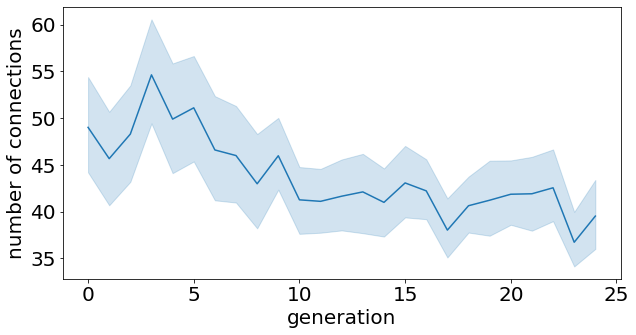

In [310]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 9 Text yticklabel objects>)

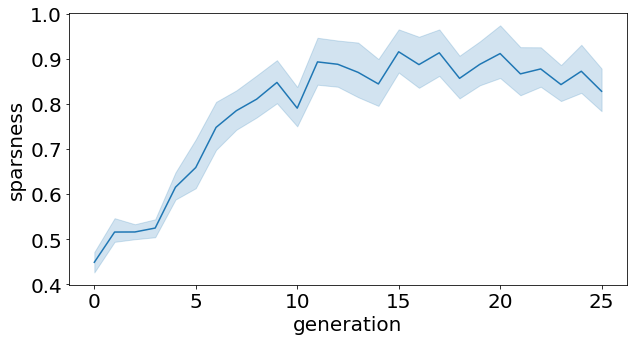

In [312]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [41]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

FileNotFoundError: [Errno 2] No such file or directory: '/home/leni/are-logs/nn2_cppn_test_allp01_smallcppn/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/MD_Cart_WDH.csv'

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 <a list of 8 Text yticklabel objects>)

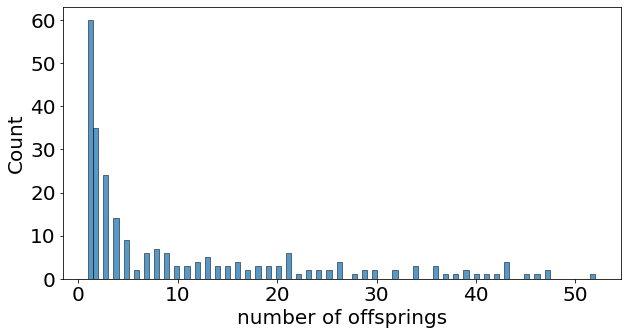

In [315]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.histplot(data=data,x="number of offsprings",bins=100)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

[4990, 903, 113, 27]
[[25, 83], [5, 73], [1, 30], [0, 27]]
[[13, 20], [14, 23], [14, 23], [14, 24]]


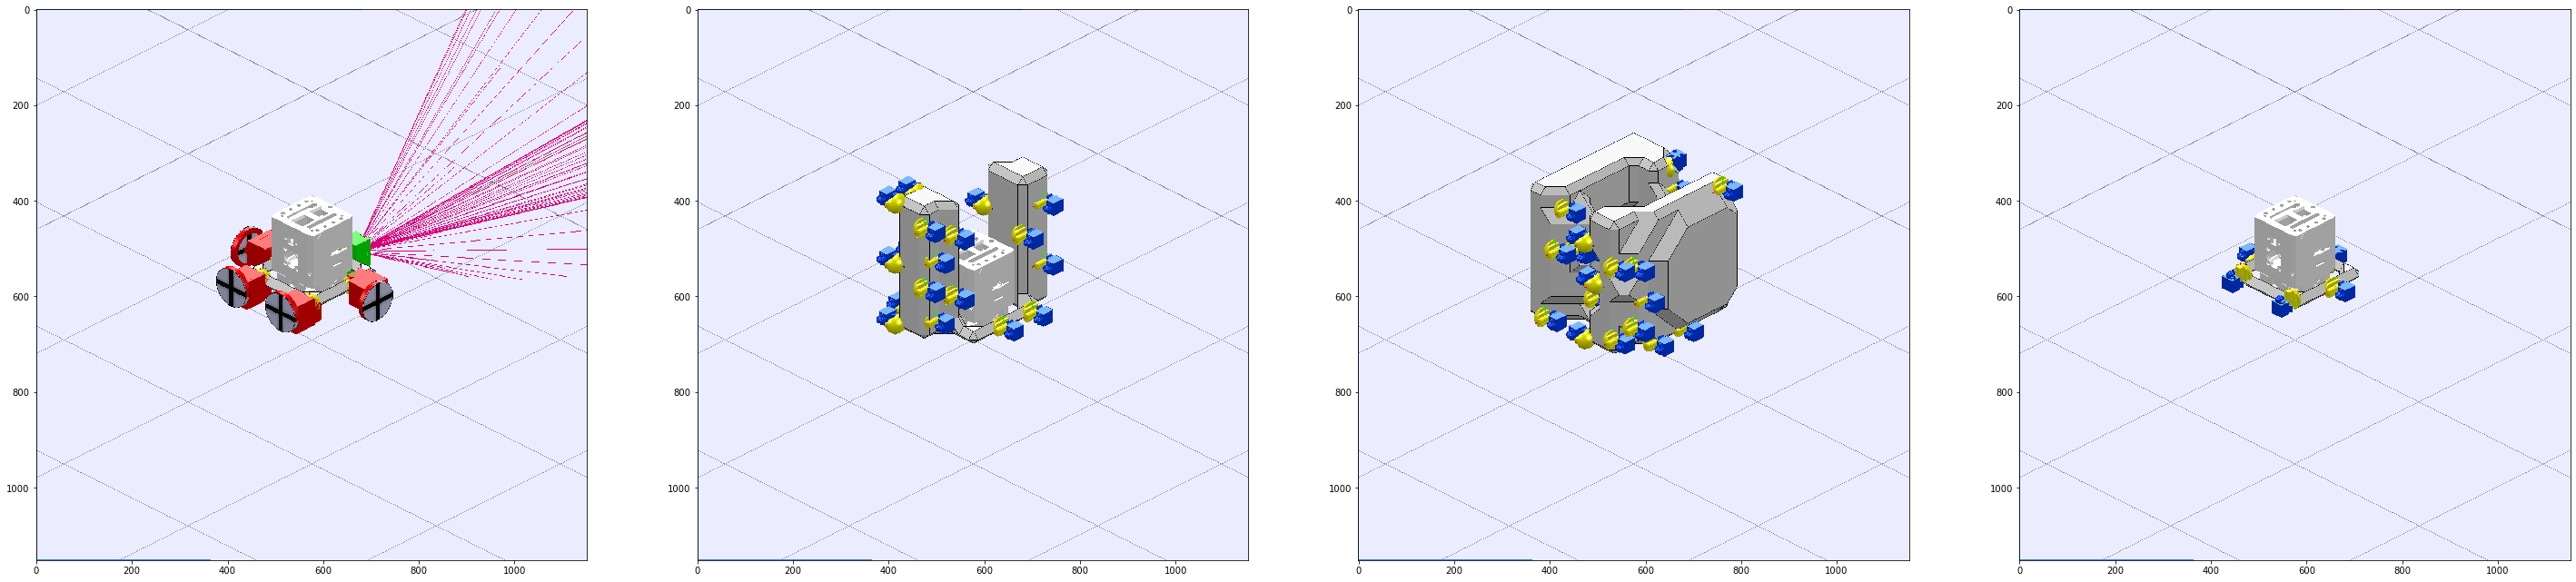

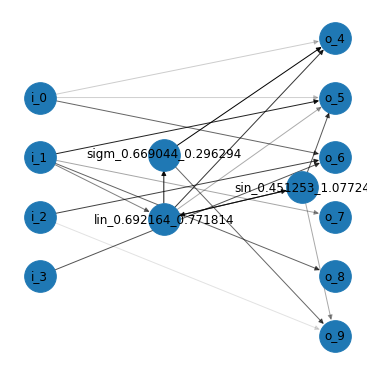

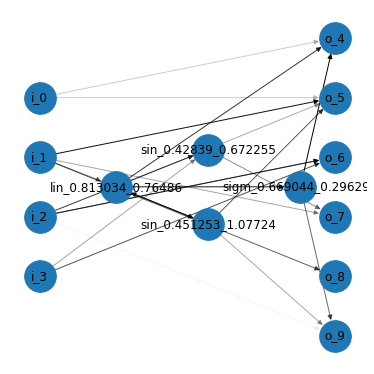

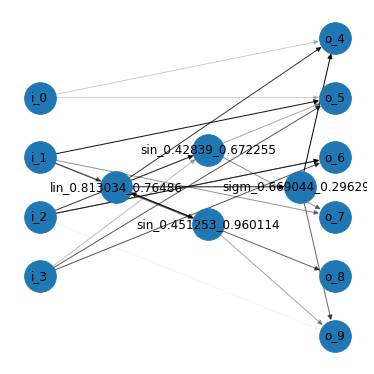

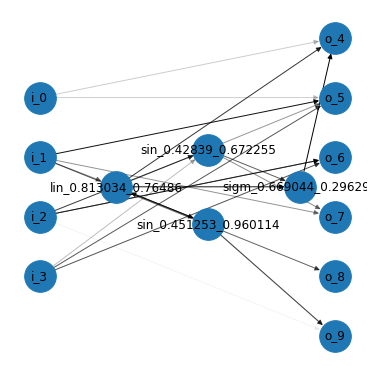

In [420]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/parenting.csv",4990,100)
nb_con_neu = load_nbr_con_neu(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/nbr_conn_neu.csv")
nbr_conn_neur = dict()
for ncn in nb_con_neu:
    nbr_conn_neur[ncn[0]] = ncn[1:]
print(lineage)
print([id_to_gen_index[l] for l in lineage])
print([nbr_conn_neur[l] for l in lineage])

images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
draw_cppns(lineage,exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/")

[2100, 957, 794, 142, 66]
[[11, 48], [5, 12], [4, 63], [1, 54], [0, 66]]
[[14, 33], [14, 33], [14, 33], [14, 33], [14, 32]]


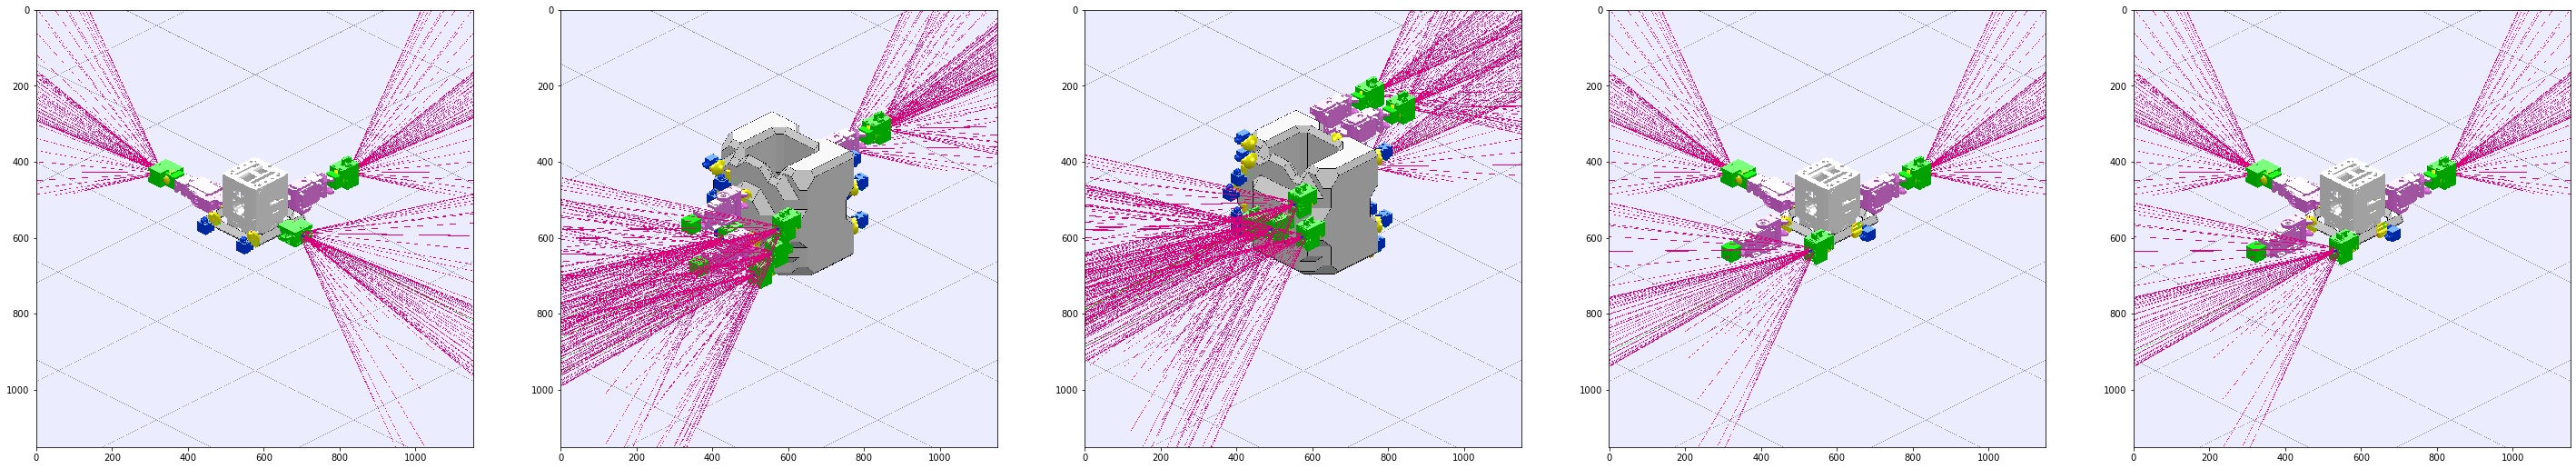

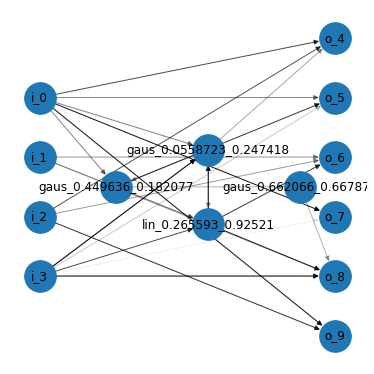

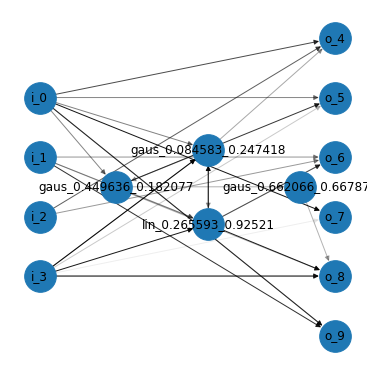

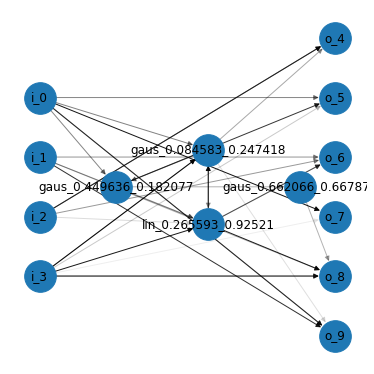

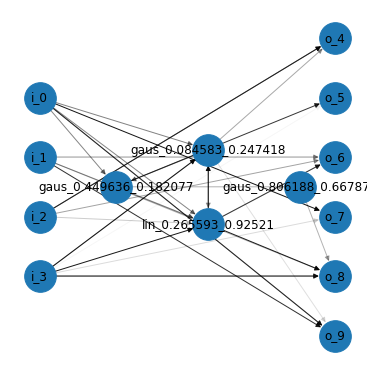

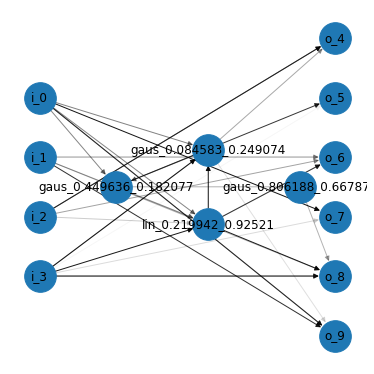

In [421]:
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/parenting.csv",2100,100)
nb_con_neu = load_nbr_con_neu(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/nbr_conn_neu.csv")
nbr_conn_neur = dict()
for ncn in nb_con_neu:
    nbr_conn_neur[ncn[0]] = ncn[1:]
print(lineage)
print([id_to_gen_index[l] for l in lineage])
print([nbr_conn_neur[l] for l in lineage])

images = []
for l in lineage:
    image_name = "robot_" + str(id_to_gen_index[l][0]) + "_" + str(id_to_gen_index[l][1]) + "_3.png"
    img = Image.open(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/images/" + image_name)
    images.append(img)

columns = len(images)
height = len(images) * 50
plt.figure(figsize=(50, height))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
draw_cppns(lineage,exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/")

[(0, 0, 0, 0.0716305), (0, 0, 0, 0.190072), (0, 0, 0, 0.7841), (0, 0, 0, 0.982957), (0, 0, 0, 0.727321), (0, 0, 0, 0.857787), (0, 0, 0, 0.638833), (0, 0, 0, 0.956704), (0, 0, 0, 0.85221), (0, 0, 0, 0.285527), (0, 0, 0, 0.0299816), (0, 0, 0, 0.699463), (0, 0, 0, 0.592741), (0, 0, 0, 0.471036), (0, 0, 0, 0.806993), (0, 0, 0, 0.440906), (0, 0, 0, 0.271002), (0, 0, 0, 0.393732), (0, 0, 0, 0.10228), (0, 0, 0, 0.858904), (0, 0, 0, 0.0718532), (0, 0, 0, 0.267783), (0, 0, 0, 0.459421), (0, 0, 0, 0.333725), (0, 0, 0, 0.0642448), (0, 0, 0, 0.176884), (0, 0, 0, 0.269576), (0, 0, 0, 0.828553), (0, 0, 0, 0.898074), (0, 0, 0, 0.729903), (0, 0, 0, 0.345897), (0, 0, 0, 0.298915), (0, 0, 0, 0.308022), (0, 0, 0, 0.218936), (0, 0, 0, 0.773098), (0, 0, 0, 0.422743), (0, 0, 0, 0.358646), (0, 0, 0, 0.147886), (0, 0, 0, 0.741175), (0, 0, 0, 0.360213), (0, 0, 0, 0.347719), (0, 0, 0, 0.997875), (0, 0, 0, 0.214038), (0, 0, 0, 0.598896), (0, 0, 0, 0.757656), (0, 0, 0, 0.699997), (0, 0, 0, 0.661516), (0, 0, 0, 0.

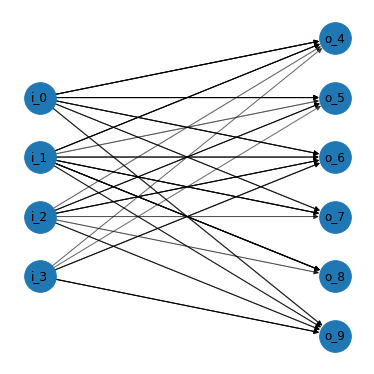

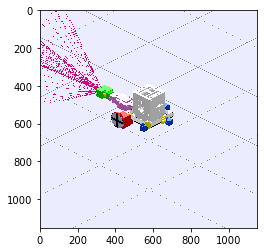

In [439]:
draw_cppns([342],exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/")
plt.show()
image_name = "robot_" + str(id_to_gen_index[342][0]) + "_" + str(id_to_gen_index[342][1]) + "_3.png"
image = Image.open(exp_folder + "/bodyplantesting_nn2_7_9_11-40-5-5804-2264064849/images/" + image_name)
plt.imshow(image)

In [38]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_allp01_smallcppn/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

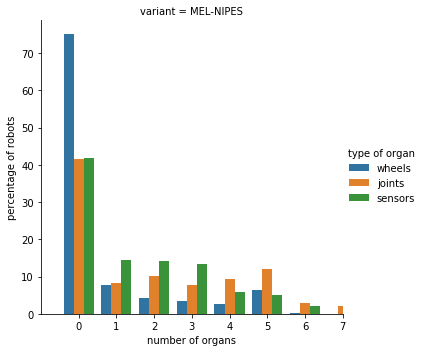

In [4]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [5]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_12_9_16-31-57-7284-3971512572
bodyplantesting_nn2_8_9_11-1-25-5505-4238153022


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 <a list of 8 Text yticklabel objects>)

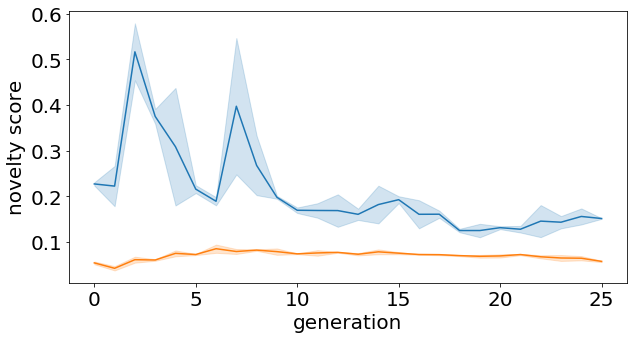

In [6]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [7]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_12_9_16-31-57-7284-3971512572
bodyplantesting_nn2_8_9_11-1-25-5505-4238153022


(array([10.75, 11.  , 11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75,
        13.  ]),
 <a list of 10 Text yticklabel objects>)

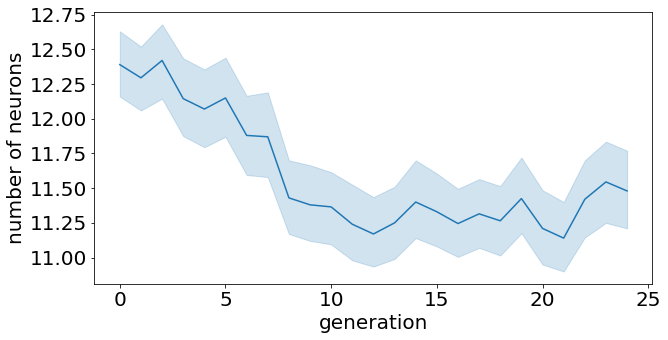

In [8]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([40., 45., 50., 55., 60., 65., 70.]),
 <a list of 7 Text yticklabel objects>)

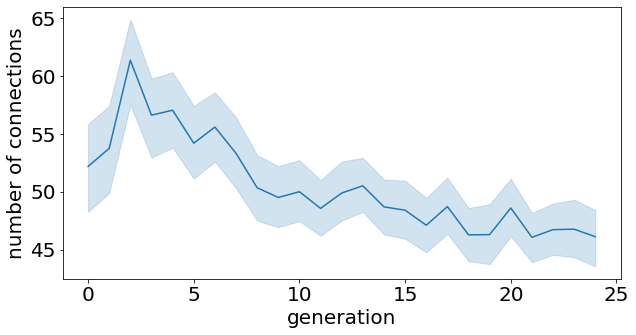

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

NameError: name 'big_data' is not defined

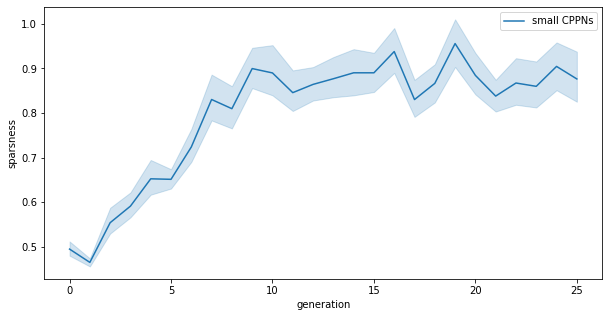

In [10]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_8_9_11-1-25-5505-4238153022/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness",label="small CPPNs")
sns.lineplot(data=big_data,x="generation",y="sparsness",label="big CPPNs")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 7 Text yticklabel objects>)

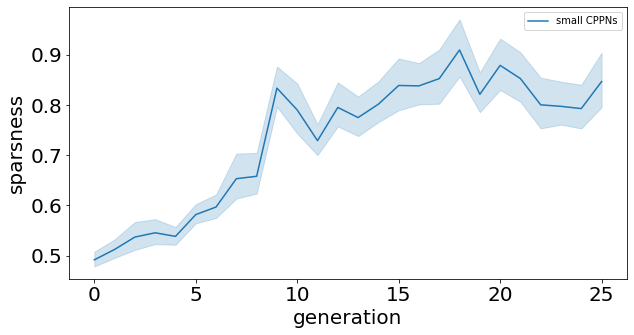

In [12]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_12_9_16-31-57-7284-3971512572/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness",label="small CPPNs")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text yticklabel objects>)

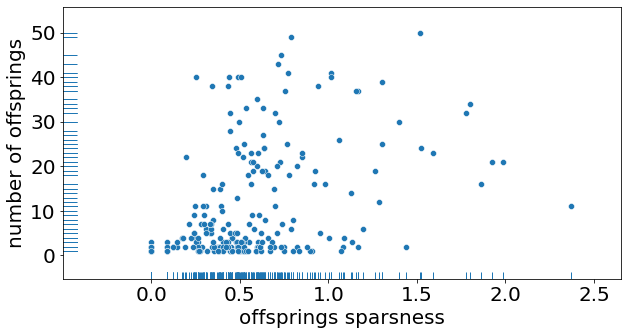

In [42]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_8_9_11-1-25-5505-4238153022/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_8_9_11-1-25-5505-4238153022/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","offsprings sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <a list of 10 Text yticklabel objects>)

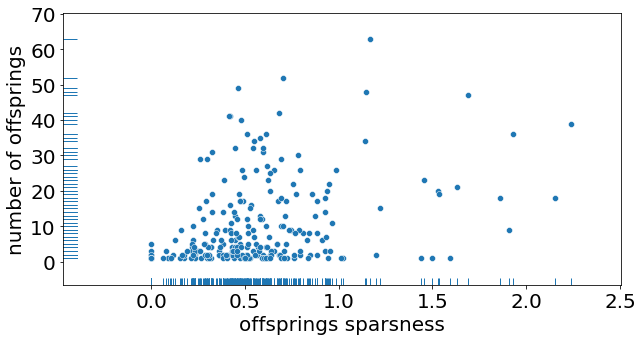

In [43]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_12_9_16-31-57-7284-3971512572/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, lineage = load_lineage(exp_folder + "/bodyplantesting_nn2_12_9_16-31-57-7284-3971512572/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","offsprings sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

[(0, 0, 0, 0.454742), (0, 0, 0, 0.431226), (0, 0, 0, 0.721635), (0, 0, 0, 0.269092), (0, 0, 0, 0.23668), (0, 0, 0, 0.637521), (0, 0, 0, 0.922332), (0, 0, 0, 0.72112), (0, 0, 0, 0.525681), (0, 0, 0, 0.295254), (0, 0, 0, 0.694743), (0, 0, 0, 0.489594), (0, 0, 0, 0.693788), (0, 0, 0, 0.224277), (0, 0, 0, 0.646477), (0, 0, 0, 0.417047), (0, 0, 0, 0.278558), (0, 0, 0, 0.739072), (0, 0, 0, 0.0499947), (0, 0, 0, 0.0319226), (0, 0, 0, 0.39902), (0, 0, 0, 0.980904), (0, 0, 0, 0.81095), (0, 0, 0, 0.102343), (0, 0, 0, 0.470625), (0, 0, 0, 0.101534), (0, 0, 0, 0.126015), (0, 0, 0, 0.721753), (0, 0, 0, 0.133504), (0, 0, 0, 0.0426599), (0, 0, 0, 0.840046), (0, 0, 0, 0.662261), (0, 0, 0, 0.413901), (0, 0, 0, 0.0990896), (0, 0, 0, 0.398282), (0, 0, 0, 0.122021), (0, 0, 0, 0.329175), (0, 0, 0, 0.909103), (0, 0, 0, 0.450943), (0, 0, 0, 0.714472), (0, 0, 0, 0.0885184), (0, 0, 0, 0.743604), (0, 0, 0, 0.372313), (0, 0, 0, 0.360637), (0, 0, 0, 0.249549), (0, 0, 0, 0.908615), (0, 0, 0, 0.134215), (0, 0, 0, 0

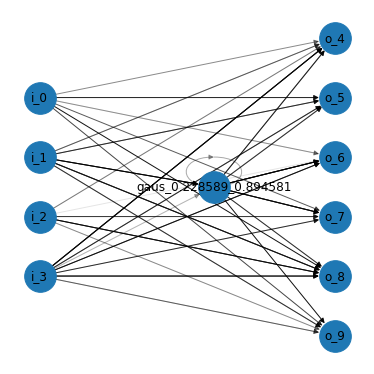

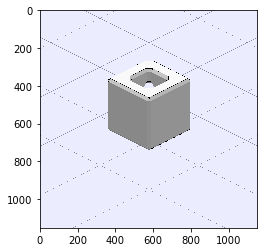

In [20]:
edge_labels, node_labels = draw_cppns([4990],exp_folder + "/bodyplantesting_nn2_12_9_16-31-57-7284-3971512572/")
print(edge_labels)
plt.show()
image_name = "robot_" + str(id_to_gen_index[4990][0]) + "_" + str(id_to_gen_index[4990][1]) + "_3.png"
image = Image.open(exp_folder + "/bodyplantesting_nn2_12_9_16-31-57-7284-3971512572/images/" + image_name)
plt.imshow(image)

In [46]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_xover_allmp005/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

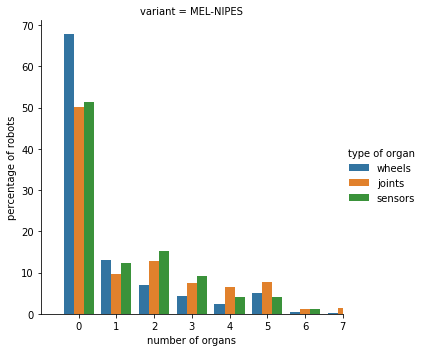

In [22]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [23]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_13_9_10-56-8-8796-2015085112


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), <a list of 6 Text yticklabel objects>)

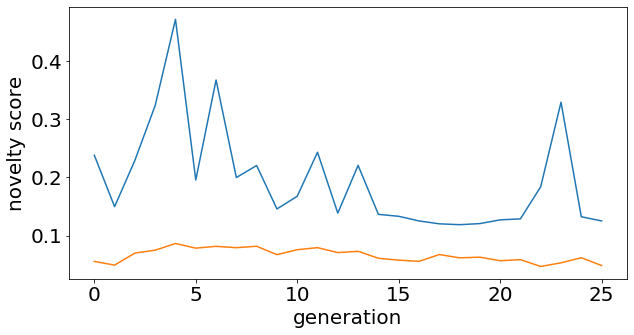

In [24]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [25]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_13_9_10-56-8-8796-2015085112


(array([10.5, 11. , 11.5, 12. , 12.5, 13. ]),
 <a list of 6 Text yticklabel objects>)

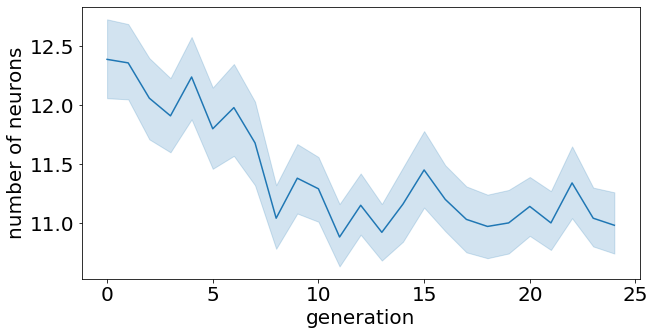

In [26]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([40., 45., 50., 55., 60., 65.]), <a list of 6 Text yticklabel objects>)

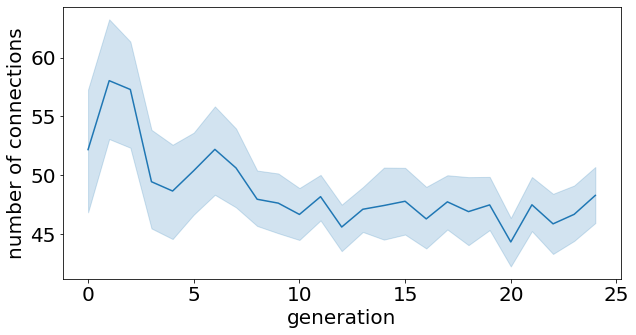

In [27]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 7 Text yticklabel objects>)

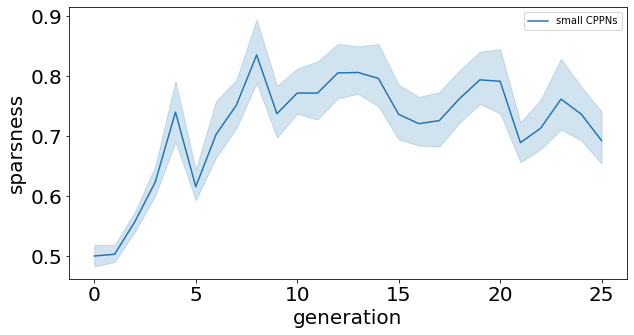

In [29]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_13_9_10-56-8-8796-2015085112/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness",label="small CPPNs")

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

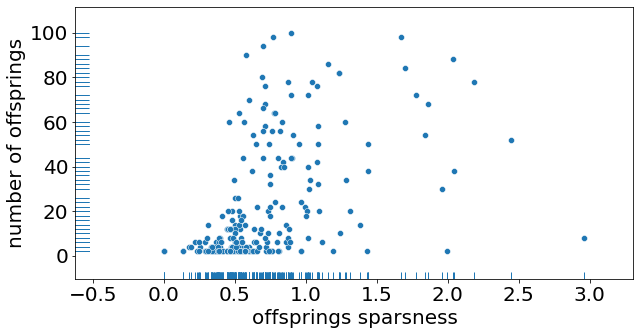

In [47]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_13_9_10-56-8-8796-2015085112/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, parenting = load_lineage_gen(exp_folder + "/bodyplantesting_nn2_13_9_10-56-8-8796-2015085112/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","offsprings sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [2]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_allmp005/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

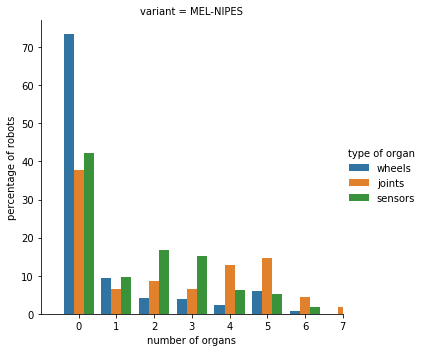

In [3]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [4]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_13_9_16-26-34-4220-4241270268


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text yticklabel objects>)

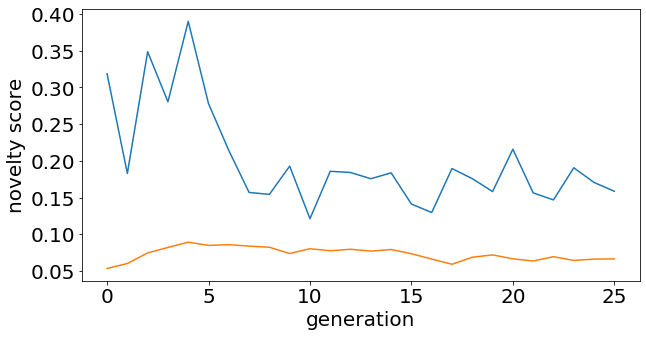

In [5]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [6]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_13_9_16-26-34-4220-4241270268


(array([10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5]),
 <a list of 7 Text yticklabel objects>)

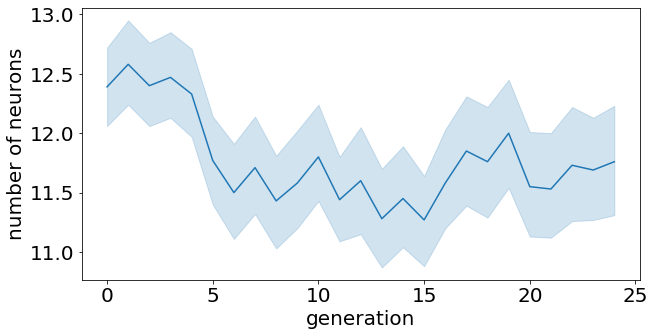

In [7]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5, 55. , 57.5, 60. ]),
 <a list of 11 Text yticklabel objects>)

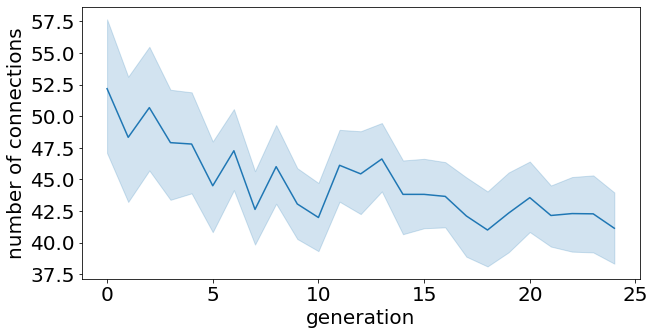

In [8]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 7 Text yticklabel objects>)

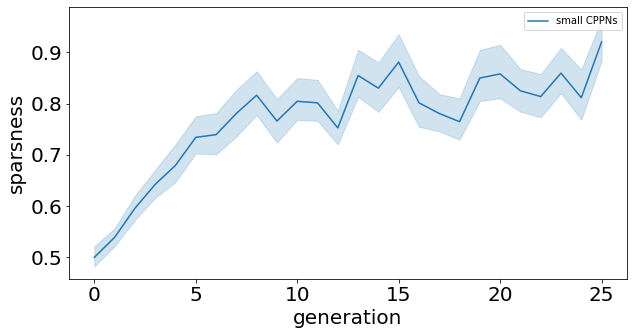

In [10]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_13_9_16-26-34-4220-4241270268/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness",label="small CPPNs")

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 9 Text yticklabel objects>)

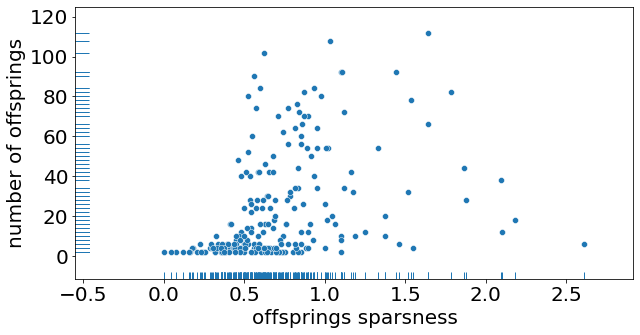

In [12]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_13_9_16-26-34-4220-4241270268/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, parenting = load_lineage_gen(exp_folder + "/bodyplantesting_nn2_13_9_16-26-34-4220-4241270268/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","offsprings sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [2]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_xover/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

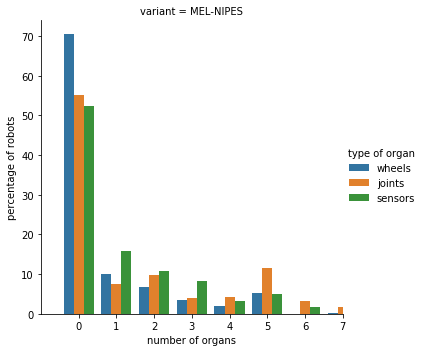

In [3]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [4]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_14_9_14-18-26-6399-4110212868


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text yticklabel objects>)

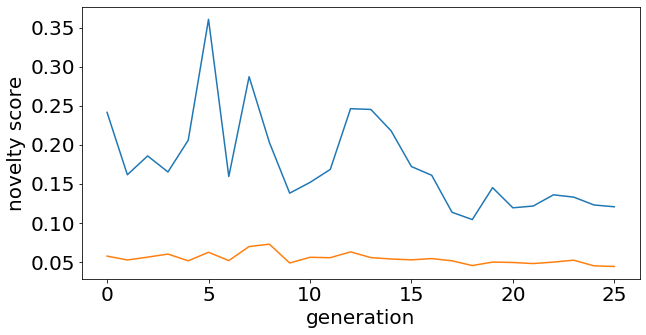

In [5]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [6]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_14_9_14-18-26-6399-4110212868


(array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. ]),
 <a list of 7 Text yticklabel objects>)

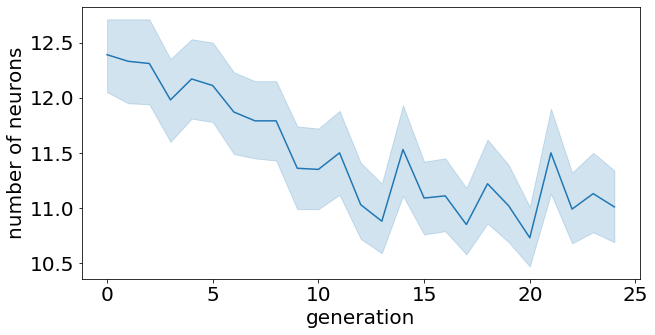

In [7]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([40., 45., 50., 55., 60., 65., 70.]),
 <a list of 7 Text yticklabel objects>)

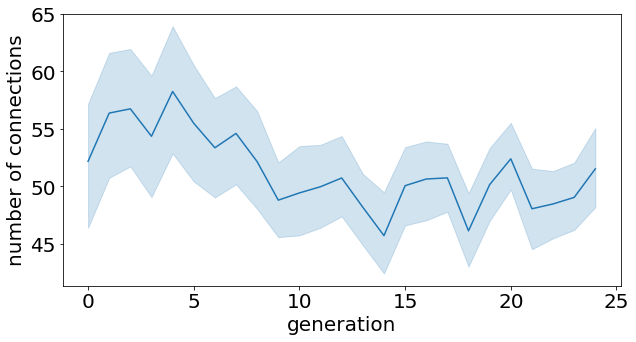

In [8]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 <a list of 10 Text yticklabel objects>)

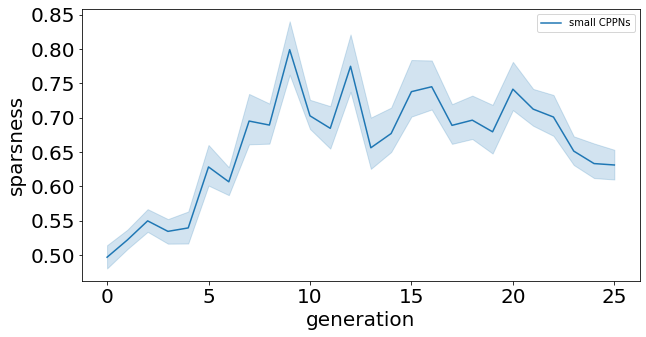

In [10]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_14_9_14-18-26-6399-4110212868/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness",label="small CPPNs")

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

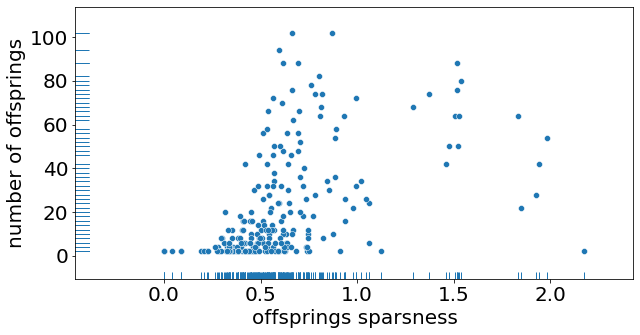

In [12]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_14_9_14-18-26-6399-4110212868/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, parenting = load_lineage_gen(exp_folder + "/bodyplantesting_nn2_14_9_14-18-26-6399-4110212868/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","offsprings sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [2]:
exp_folder = "/home/leni/are-logs/nn2_cppn_test_/"
organ_lines = []
fit_lines = []
desc_lines = []
type_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[5]*16,desc[6]*16,desc[7]*16])
        
wheels = [0 for _ in range(17)]
joints = [0 for _ in range(17)]
sensors = [0 for _ in range(17)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
        wheels[int(desc[2])]+=1
        joints[int(desc[4])]+=1
        sensors[int(desc[3])]+=1
        total+=1
for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","MEL-NIPES"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","MEL-NIPES"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","MEL-NIPES"])

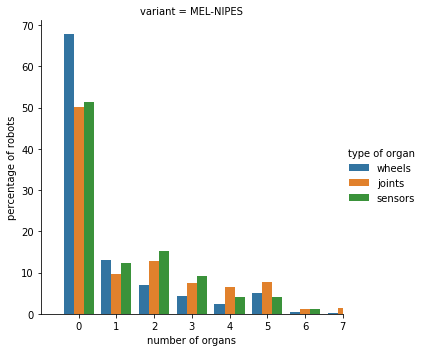

In [3]:
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar')
g.set(xlim=[-1,7])

In [8]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
        
    for gen, bf, af, in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,bf,af,])
data = pd.DataFrame(data=lines,columns=["generation","best fitness","average fitness"])

bodyplantesting_nn2_13_9_10-56-8-8796-2015085112


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), <a list of 6 Text yticklabel objects>)

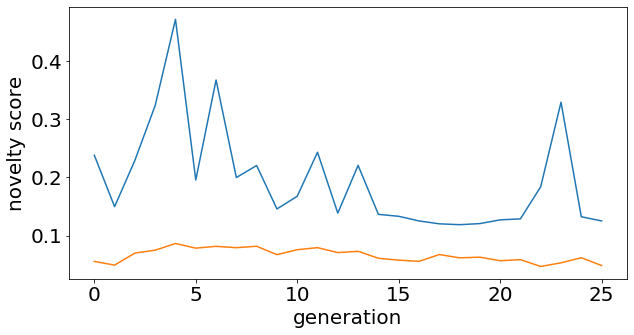

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="best fitness")
sns.lineplot(data=data,x="generation",y="average fitness")

ax.set_ylabel("novelty score")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [10]:
lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    nb_con_neu = load_nbr_con_neu(exp_folder + folder + "/nbr_conn_neu.csv")
    generations = []
    for i in range(0,25):
        generations += [i]*100
    for gen,ncn in zip(generations,nb_con_neu):
        lines.append([gen,ncn[0],ncn[1],ncn[2]])
data = pd.DataFrame(data=lines,columns=["generation","id","neurons","connections"])

bodyplantesting_nn2_13_9_10-56-8-8796-2015085112


(array([10.5, 11. , 11.5, 12. , 12.5, 13. ]),
 <a list of 6 Text yticklabel objects>)

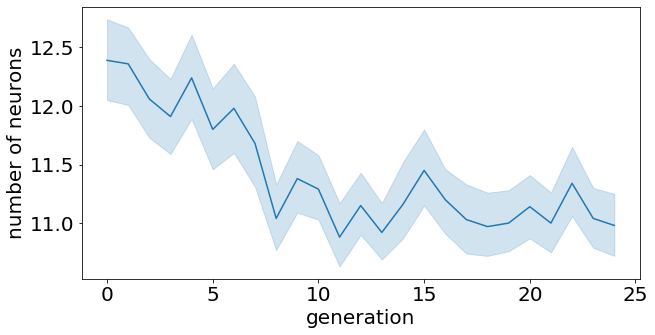

In [11]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="neurons")

ax.set_ylabel("number of neurons")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([40., 45., 50., 55., 60., 65., 70.]),
 <a list of 7 Text yticklabel objects>)

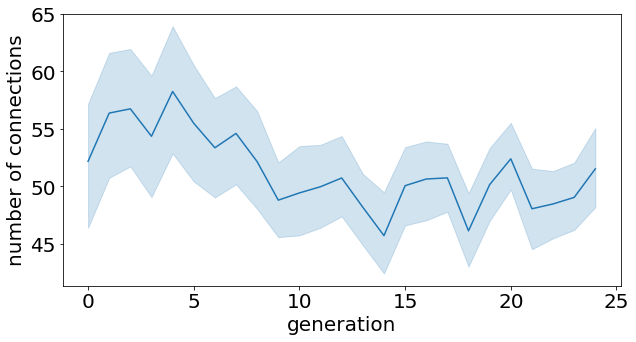

In [8]:
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="connections")

ax.set_ylabel("number of connections")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 <a list of 10 Text yticklabel objects>)

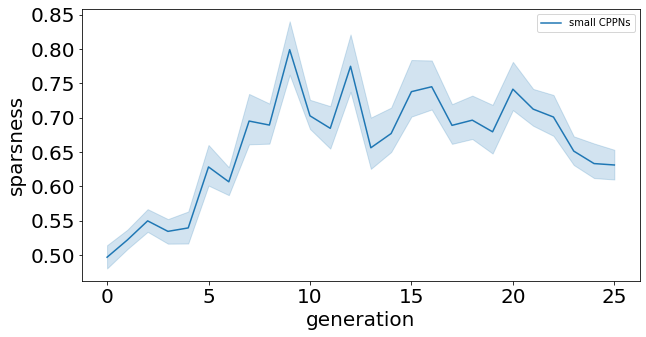

In [10]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_13_9_10-56-8-8796-2015085112/MD_Cart_WDH.csv")
sparsness = sparsness_per_gen(descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["generation","sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.lineplot(data=data,x="generation",y="sparsness",label="small CPPNs")

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

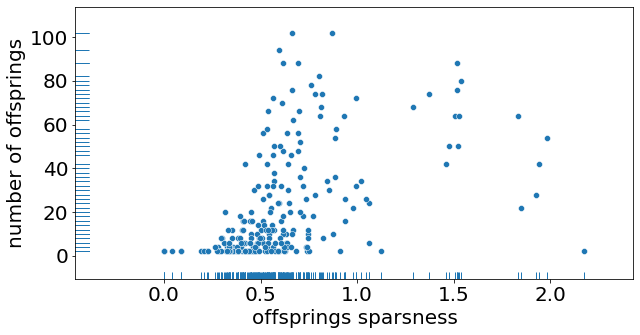

In [12]:
descriptors = load_descriptor(exp_folder + "bodyplantesting_nn2_13_9_10-56-8-8796-2015085112/MD_Cart_WDH.csv")
id_to_gen_index, offsprings, parenting = load_lineage_gen(exp_folder + "/bodyplantesting_nn2_14_9_14-18-26-6399-4110212868/parenting.csv",4994,100)
sparsness = compute_offsprings_sparsness(id_to_gen_index,offsprings,descriptors,100)
data = pd.DataFrame(data=sparsness,columns=["id","generation","distance","number of offsprings","offsprings sparsness"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax=sns.rugplot(data=data,x="offsprings sparsness",y="number of offsprings")
sns.scatterplot(data=data,x="offsprings sparsness",y="number of offsprings")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)